In [1]:
import os
import gzip
import json

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Daten aus dem Internet laden

In [2]:
BASIS_URL = 'https://www.parlament.gv.at'

#Plenarsitzungen des Nationalrats für eine gegebene Gesetzesperiode
LISTE_URL = '/PAKT/STPROT/index.shtml?SUCH=&xdocumentUri=%2FPAKT%2FSTPROT%2Findex.shtml&pageNumber=&R_PLSO=PL' + \
            '&GP={gp}&STEP=&INTRANET=N&feldRnr=1&STPROT=ALLE&ascDesc=DESC&FBEZ=FP_011&NRBRBV=NR&BEZ=FP_211' + \
            '&requestId=D6CBFB9744&LISTE=&jsMode=&listeId=211&NUR_VORL=N'


Falls schon heruntergeladene Protokolle existieren, diese laden.

In [3]:
%%time

FILE = 'protokolle_txt.json.zip'

if os.path.exists(FILE):
    # Protokolle aus Datei laden
    with gzip.open(FILE, 'rt') as f:
        protokolle_txt = json.load(f)
else:
    # Protokolle herunterladen
    protokolle_txt = dict()

Wall time: 5.55 s


Hier werden Protokolle geladen, für angegebene Gesetzesperiode. Falls bestehende Protokolle schon geladen sind, nicht nötig auszuführen.

In [4]:
%%time

# Status 8.8.2016
# Stenographische Protokolle in strukturiertem HTML Format ab XXII. Gesetzgebungsperiode (23.05.2006, 150. NR Sitzung)
# Ab XXIII. Gesetzgebungsperiode (1. Sitzung 30.10.2006) durchgehend neues Format.
# Analysiere daher ab XXIII. Gesetzgebungsperiode
# Aktuellstest Protokoll: XXV. Gesetzgebungsperiode, 24.02.2016
gesetzgebungsperioden = ('XXV', 'XXIV', 'XXIII')

for gp in gesetzgebungsperioden:
    print(' ')
    print(gp)

    # Internetseite mit Links zu den Protokollen der entsprechenden Gesetzgebungsperidoe wird abgerufen
    r = requests.get(BASIS_URL + LISTE_URL.format(gp = gp))

    soup = BeautifulSoup(r.text, 'lxml')

    # Alle Links in der Ergebnistabelle
    links = soup.find('table', class_='tabelle filter').find_all('a')
    # Davon alle auf Stenographisches Protokoll in HTML Format
    links = [link for link in links if link.text == 'HTML']
    # Davon die URL
    links = [link.get('href') for link in links]

    for link in links:
        # In der URL steckt die Nummer der Sitzung, der zur Information ausgegeben wird
        print(link.split('/')[5].split('_')[1], end=' ')
        # Eindeutiger key des Protokolls, bestehend aus Gesetzperiode, Art der Sitzung (Nationalrat) und Nummer
        key = gp + '_' + link.split('/')[5]
        r_temp = requests.get(BASIS_URL + link)
        protokolle_txt[key] = r_temp.text
        
print()
# Protokolle in gezippten JSON File speichern
with gzip.open(FILE, mode="wt") as f:
    json.dump(protokolle_txt, f)

 
XXV
00114 00113 00112 00111 00110 00109 00108 00107 00106 00105 00103 00102 00101 00100 00099 00098 00097 00096 00095 00094 00093 00092 00091 00090 00089 00088 00087 00086 00085 00084 00083 00082 00081 00080 00079 00078 00077 00076 00075 00074 00073 00072 00071 00070 00069 00068 00067 00066 00065 00064 00063 00062 00061 00060 00059 00058 00057 00056 00055 00054 00053 00052 00051 00050 00049 00048 00047 00046 00045 00044 00043 00042 00041 00040 00039 00038 00037 00036 00035 00034 00033 00032 00031 00030 00029 00028 00027 00026 00025 00024 00023 00022 00021 00020 00019 00018 00017 00016 00015 00014 00013 00012 00011 00010 00009 00008 00007 00006 00005 00004 00003 00002 00001  
XXIV
00220 00219 00218 00217 00216 00215 00214 00213 00212 00211 00210 00209 00208 00207 00206 00205 00204 00203 00202 00201 00200 00199 00198 00197 00196 00195 00194 00193 00192 00191 00190 00189 00188 00187 00186 00185 00184 00183 00182 00181 00180 00179 00178 00177 00176 00175 00174 00173 00172 00171 00170 001

In [4]:
len(protokolle_txt)

409

Wir haben also 409 Nationalratssitzungen. Jeder der Sitzungen ist im HTML-Format gespeichert.

In [5]:
protokolle_txt['XXIII_NRSITZ_00043'][:400]

'<html>\r\n<head>\r\n<meta http-equiv=Content-Type content="text/html; charset=us-ascii">\r\n<meta name=Generator content="Microsoft Word 11 (filtered)">\r\n<title>Parlamentarische Materialien</title>\r\n<style>\r\n</style>\r\n<link rel=stylesheet type=text/css href="/PAKT/VHG/XXIII/NRSITZ/NRSITZ_00043/NRSP_043.css"><link rel="stylesheet" type="text/css" href="/styles/PDSteno.css"></head>\r\n<body lang=DE-AT>\r\n<di'

# Protokolle analysieren und Reden auslesen

Falls die Protokolle schon ausgelsen wurden und strukturiert in einem Datenframe gespeichert wurden, wird die Datei nun eingelesen.

In [6]:
%%time

FILE = 'df_protokolle.pkl'

if os.path.exists(FILE):
    # Protokolle aus Datei laden
    df = pd.read_pickle(FILE)

Wall time: 375 ms


Hier werden Protokolle ausgelesen und ausgewählte Elemente in einen Datenframe gespeichert. Das dauert einige Zeit.  Falls entsprechende Datenframe schon geladen ist und kein neues Parsen gewünscht wird, nicht ausführen.

In [79]:
%%time

# key_okay speichert alle Protokolle, die bereits ausgelesen wurden.
# Nun sollte das Auslesen in einem Lauf funktioneren. Während des Entwickeln des Codes, 
# wurde der folgende Code öfters ausgeführt und ich wollte nicht jedesmal ganz von vorne anfangen.
key_okay=[]

# Ergebnis wird in einem Datenframe gespeichert
df = pd.DataFrame()
# Countdown damit man sieht, wie viele Protokolle noch ausgelesen werden müssen
countdown = len(protokolle_txt) - len(key_okay)

for key in protokolle_txt:
#for key in ('XXIV_NRSITZ_00207',):
    if key in key_okay:
        continue
    countdown = countdown - 1
    
    # HTML-Protokoll parsen mittels BeautifulSoup
    txt = protokolle_txt[key]
    soup = BeautifulSoup(txt, 'lxml')
    
    # Bei manchen Sitzungen gibt es Fehler bei den IDs (Name, Datum, ...).
    # Diese werden manuell überschrieben
    if key == 'XXIV_NRSITZ_00026':
        # Falsche IDs in entsprechendem Protokoll
        sitzung = '26. Sitzung des\r\nNationalrates der Republik Österreich'
        periode = 'XXIV. Gesetzgebungsperiode'
        datum = 'Dienstag, 16. Juni 2009'
    elif key == 'XXIII_NRSITZ_00060':    
        # Falsche IDs in entsprechendem Protokoll
        sitzung = '60. Sitzung des\r\nNationalrates der Republik Österreich'
        periode = 'XXIII. Gesetzgebungsperiode'
        datum = 'Donnerstag, 8. Mai 2008'        
    # Normalerweise lassen sich die IDs auslesen, Identifikation anhand HTML-Class IDs
    else:
        sitzung = soup.find('p', class_='DBl02').get_text()
        periode = soup.find('p', class_='DBl04').get_text()
        datum = soup.find('p', class_='DBl05').get_text()

    # Nochmals eine manuelle Datenbereinigung
    if key == 'XXIV_NRSITZ_00220':
        sitzung = '220. Sitzung des\r\nNationalrates der Republik Österreich'
        
    if key == 'XXV_NRSITZ_00001':
        datum = 'Dienstag, 29. Oktober 2013'

    if key == 'XXIII_NRSITZ_00021':    
        datum = 'Donnerstag, 3. Mai 2007' 
    
    print(countdown, ' - ', key, ' - ', periode[:periode.find('.')], ' - ', sitzung[:sitzung.find('.')])
    
    # Normalerweise sind Reden an HTML-Class 'StandardRB' (RB scheint für Rede-Beginn zu stehen) erkennbar
    rede_pos = soup.find('p', class_='StandardRB')

    while rede_pos != None:
        # Nun wird der Text der Rede ausgelesen.
        # Zuerst der Text des Paragraphs mit der 'StandardRB'-Class
        rede_txt = rede_pos.get_text()
        # Doch leider kann der Text über mehrere Paragraphen gehen.
        # Zusätzlich Reden des Schriftführers/der Schriftführerin ausschließen, gibt es bei den Angelobungen neuer
        # Abgeordneter, inklusive der Antworten "Ich gelobe." 
        # Hier gibt es oft Probleme mit den HTML-Classes, ebenso bei 
        while ((rede_txt.startswith('Schriftführer') == False) & 
               (max(rede_txt.find('Ich gelobe.'),rede_txt.find('Ich\r\ngelobe.')) == -1)):
            # Identifikation der HTML Klasse des nächsten Paragraphs
            rede_pos = rede_pos.find_next('p')
            klasse = rede_pos['class'] 
            # Paragraphen mit den folgenden Klassen sind eine Fortsetzung der Rede.
            # Daher wird der Text zur bestehenden Rede hinzugefügt 
            if klasse in (['MsoNormal'], ['StandardRB'], ['MsoBodyText'], ['MsoListBullet'], 
                          ['INHANTR'], 
                          ['MsoListBulletCxSpFirst'], ['MsoListBulletCxSpMiddle'], ['MsoListBulletCxSpLast'], 
                          ['MsoBodyText2'], ['MsoNormalCxSpMiddle']) :
                # INHANTR z.B. wegen XXII_NRSITZ_00058
                # MsoListBulletCxSpFirst, ...Middle und ... Last z.B. wegen XXV_NRSITZ_00012
                # MsoBodyText2 z.B wegen XXII_NRSITZ_00051, könnte man auch als Ende verwenden 
                # MsoNormalCxSpMiddle z.B. wegen XXIV_NRSITZ_00159
                rede_txt = rede_txt + rede_pos.get_text()
            # Die folgenden Klassen markieren das Ende einer Rede 
            elif klasse in (['StandardRE'], ['RE'], ['StandardR'], ['SB'], ['RE0']):
                # RE0 z.B. wegen XXII_NRSITZ_00035
                rede_txt = rede_txt + rede_pos.get_text()
                df = df.append({'key':key, 'sitzung': sitzung, 'periode': periode, 'datum': datum, 'rede': rede_txt}, 
                               ignore_index=True)
                break
            # Die folgenden Klassen markieren einen Zwischentext, der nicht Teil der Rede ist
            elif klasse in (['ZM'],['RB'], ['Format1']):
                # 'ZM' - Entschließungsantrag
                # 'RB' - Redebeginn, nicht benötigt, verwende StandardRB
                pass
            # Nicht oben erwähnte Klasse führt zu Fehlermeldung und speichert Dokument, 
            # damit es genauer analysiert werden kann.
            # Wurde während der Entwicklung verwendet, sollte jetzt nicht vorkommen, es sei denn,
            # es kommen neue Protokolle mit neuen Formatierungen vor
            else:
                print(key)
                print(klasse)
                print(rede_txt)
                with open('temp.html', 'w', encoding='utf8') as fp:
                    fp.write(protokolle_txt[key])
                raise ValueError('Unerwartetes Element in Rede')
        
        # Finde Start der nächsten Rede
        if key == 'XXIV_NRSITZ_00120':
            # 'Falsches StandardR in entsprechendem Protokoll
            rede_pos = rede_pos.find_next('p', class_=lambda x: x in ('StandardRB', 'StandardR'))
        else:
            rede_pos = rede_pos.find_next('p', class_='StandardRB')
            
            
    key_okay.append(key)
    
df.to_pickle('df_protokolle.pkl')

408  -  XXIII_NRSITZ_00028  -  XXIII  -  28
407  -  XXIV_NRSITZ_00022  -  XXIV  -  22
406  -  XXV_NRSITZ_00013  -  XXV  -  13
405  -  XXIII_NRSITZ_00043  -  XXIII  -  43
404  -  XXIV_NRSITZ_00065  -  XXIV  -  65
403  -  XXIV_NRSITZ_00213  -  XXIV  -  213
402  -  XXIII_NRSITZ_00018  -  XXIII  -  18
401  -  XXIV_NRSITZ_00050  -  XXIV  -  50
400  -  XXIV_NRSITZ_00146  -  XXIV  -  146
399  -  XXIV_NRSITZ_00026  -  XXIV  -  26
398  -  XXIV_NRSITZ_00205  -  XXIV  -  205
397  -  XXV_NRSITZ_00083  -  XXV  -  83
396  -  XXV_NRSITZ_00086  -  XXV  -  86
395  -  XXIV_NRSITZ_00006  -  XXIV  -  6
394  -  XXIII_NRSITZ_00036  -  XXIII  -  36
393  -  XXIV_NRSITZ_00057  -  XXIV  -  57
392  -  XXIII_NRSITZ_00008  -  XXIII  -  8
391  -  XXIV_NRSITZ_00017  -  XXIV  -  17
390  -  XXV_NRSITZ_00092  -  XXV  -  92
389  -  XXIII_NRSITZ_00002  -  XXIII  -  2
388  -  XXIV_NRSITZ_00049  -  XXIV  -  49
387  -  XXIV_NRSITZ_00148  -  XXIV  -  148
386  -  XXIV_NRSITZ_00158  -  XXIV  -  158
385  -  XXIII_NRSITZ_00065  

Die Sitzung XXIII_NRSITZ_00076 oben ist keine echte Sitzung, deshalb oben keine richtige Nummer. Spielt haber keine Rolle, da diese Sitzung eh keine Rede enthält.

Die folgenden drei Zellen wurden verwendet, um während der Entwicklung des Codes für einzelne Protokolle das entsprechende HTML File zu schreiben. Dieses konnte dann im Browser analysiert werden. 

In [7]:
#print(key)

In [8]:
#with open('temp.html', 'w', encoding='utf8') as fp:
#    fp.write(protokolle_txt[key])

In [9]:
#with open('temp.html', 'w', encoding='utf8') as fp:
#    fp.write(protokolle_txt['XXIII_NRSITZ_00021'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30820 entries, 0 to 30819
Data columns (total 5 columns):
datum      30820 non-null object
key        30820 non-null object
periode    30820 non-null object
rede       30820 non-null object
sitzung    30820 non-null object
dtypes: object(5)
memory usage: 1.2+ MB


Wir haben also mehr als 30.000 Reden. So sehen die einzelnen Zeilen aus, pro Zeile gibt es eine Rede.

In [11]:
df[:3]

datum                 key                      periode  \
0  Donnerstag, 5. Juli 2007  XXIII_NRSITZ_00028  XXIII. Gesetzgebungsperiode   
1  Donnerstag, 5. Juli 2007  XXIII_NRSITZ_00028  XXIII. Gesetzgebungsperiode   
2  Donnerstag, 5. Juli 2007  XXIII_NRSITZ_00028  XXIII. Gesetzgebungsperiode   

                                                rede  \
0  Abgeordneter\r\nDr. Peter Pilz (Grüne): Frau\r...   
1  Abgeordneter\r\nDr. Günther Kräuter (SPÖ):\r\n...   
2  Abgeordneter\r\nHeinz-Christian Strache (FPÖ):...   

                                             sitzung  
0  28. Sitzung des\r\nNationalrates der Republik ...  
1  28. Sitzung des\r\nNationalrates der Republik ...  
2  28. Sitzung des\r\nNationalrates der Republik ...

In [12]:
# Die Spalte periode wird verkürzt, nur der Wert, nicht noch der Text 'Gesetzgebungsperiode'
df.periode = df.periode.str.split('.',expand=True)[0]

# Datum

Nun wollen wir das Datum bereinigen. Leider gibt es hier ein paar Sonderfälle, nämlich Sitzungen über mehrere Tage. Wir nehmen hier einfach den letzten Tag. Im Beispiel also den 29. Mai 2009.

In [13]:
df.loc[df.key=='XXIV_NRSITZ_00023', 'datum'].iloc[0]

'Mittwoch, 20., Dienstag, 26., Mittwoch, 27.,\r\nDonnerstag, 28., und Freitag, 29. Mai 2009'

In [14]:
df.datum = df.datum.str.rsplit(',', expand=True, n=1)[1].str.strip()

In [15]:
df.loc[df.key=='XXIV_NRSITZ_00023', 'datum'].iloc[0]

'29. Mai 2009'

Nun wird das Textformat, z.B. '29. Mai 2009' in ein Python-Datumsformat umgewandelt.

In [16]:
# Interessanterweise gibt es sowohl Februar als auch Feber
map_monat = {'Jänner':1, 'Feber':2, 'Februar':2, 'März':3, 'April':4, 'Mai':5, 'Juni':6, 'Juli':7, 'August':8,
            'September':9, 'Oktober':10, 'November':11, 'Dezember':12}
def datum_umwandeln(txt):
    txt = txt.replace('\r\n',' ').replace('\xa0', ' ')
    tag, monat, jahr = txt.split(' ',maxsplit=2)
    datum = tag + str(map_monat[monat]) + '.' + str(jahr)
    return pd.to_datetime(datum, format='%d.%m.%Y')

In [17]:
df.datum = df.datum.apply(datum_umwandeln)

In [18]:
df.groupby(df.datum.dt.year)[['key']].count()

key
datum      
2006    357
2007   3158
2008   2763
2009   4319
2010   3417
2011   3629
2012   3273
2013   2888
2014   3506
2015   3139
2016    371

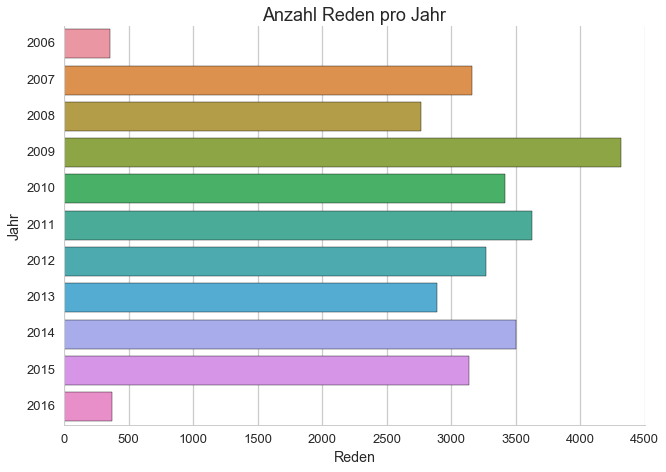

In [19]:
sns.set(context='talk', style='whitegrid')
sns.countplot(y=df.datum.dt.year, data=df)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden pro Jahr')
sns.set(font_scale=1)
sns.axlabel('Reden', 'Jahr')
sns.plt.savefig('reden_pro_jahr.svg')

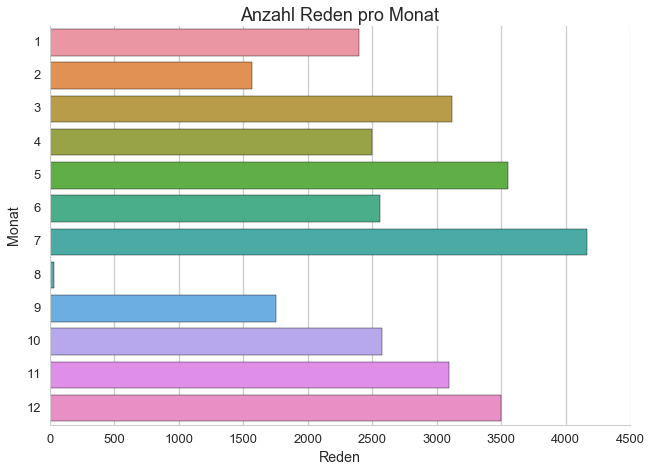

In [20]:
sns.set(context='talk', style='whitegrid')
sns.countplot(y=df.datum.dt.month, data=df)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden pro Monat')
sns.set(font_scale=1)
sns.axlabel('Reden', 'Monat')
sns.plt.savefig('reden_pro_monat.svg')

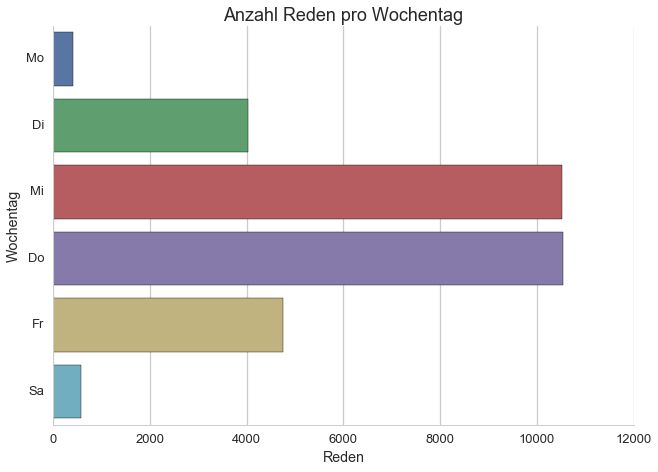

In [21]:
sns.set(context='talk', style='whitegrid')
ax = sns.countplot(y=df.datum.dt.dayofweek, data=df)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden pro Wochentag')
sns.set(font_scale=1)
sns.axlabel('Reden', 'Wochentag')
#labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa']
ax.set_yticklabels(labels)
sns.plt.savefig('reden_pro_wochentag.svg')

In [22]:
df_temp = (df.groupby([df.datum.dt.year, df.datum.dt.month])['key'].count()).unstack()
mask = df_temp.isnull()
df_temp = df_temp.fillna(value=0)
df_temp = df_temp.astype('int')
df_temp[:3]

datum   1   2    3    4    5    6    7   8    9    10   11   12
datum                                                          
2006     0   0    0    0    0    0    0   0    0   43  159  155
2007   224   0  411  106  457  306  418   0  173  242  254  567
2008   407   0  325  266  297  402  476   0  238   67   33  252

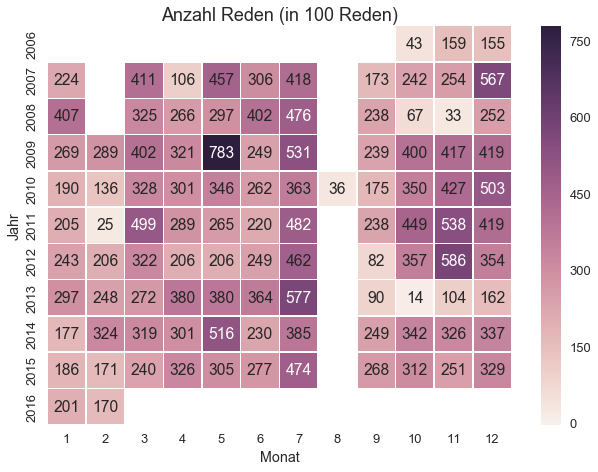

In [23]:
sns.set(context='talk', style='whitegrid')
sns.heatmap(df_temp, annot=True, linewidths=.5, fmt='d', mask=mask)
#sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden (in 100 Reden)')
sns.set(font_scale=1)
sns.axlabel('Monat', 'Jahr')
sns.plt.savefig('reden_pro_jahr_monat.svg')

In [24]:
df_temp = (df.groupby([df.datum.dt.dayofweek, df.datum.dt.year])['key'].count()).unstack()
df_temp.index = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa']
mask = df_temp.isnull()
df_temp = df_temp.fillna(value=0)
df_temp = df_temp.astype('int')
df_temp[:3]

datum  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016
Mo       43     0    70     0     0     0    21    29   196    49     0
Di        0   381   387   585   219   725   470   289   733   241     0
Mi      133   936   731   981  1746   981  1102   810  1275  1647   170

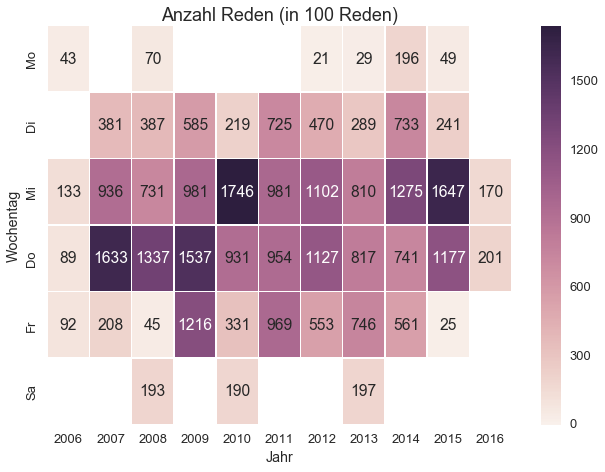

In [25]:
sns.set(context='talk', style='whitegrid')
sns.heatmap(df_temp, annot=True, linewidths=.5, fmt='d', mask=mask)
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden (in 100 Reden)')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Wochentag')
sns.plt.savefig('reden_pro_wochentag_jahr.svg')

In [26]:
df_temp = (df.groupby([df.datum.dt.dayofweek, df.datum.dt.month])['key'].count()).unstack()
df_temp.index = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa']
mask = df_temp.isnull()
df_temp = df_temp.fillna(value=0)
df_temp = df_temp.astype('int')
df_temp[:3]

datum   1    2    3    4    5    6     7   8    9    10   11    12
Mo       0  196   39   29   21   28     0   0    0   95    0     0
Di      97  223  434  463  560  306   466   0  261  292  492   436
Mi     922  653  885  756  910  974  1200  36  788  839  941  1608

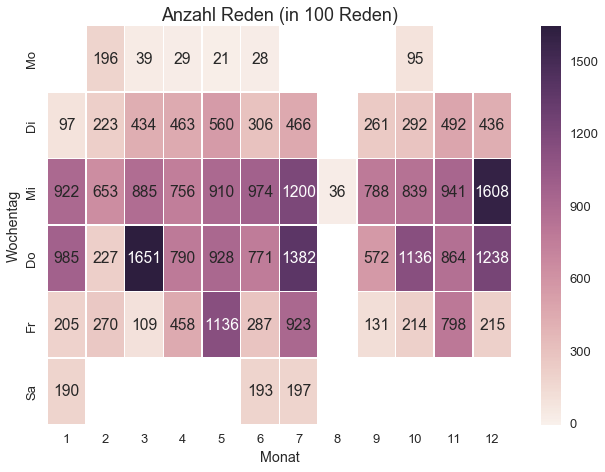

In [27]:
sns.set(context='talk', style='whitegrid')
sns.heatmap(df_temp, annot=True, linewidths=.5, fmt='d', mask=mask)
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden (in 100 Reden)')
sns.set(font_scale=1)
sns.axlabel('Monat', 'Wochentag')
sns.plt.savefig('reden_pro_wochentag_monat.svg')

# Redner auslesen

Der Redner ist der erste Teil des Felds rede. Dieser soll herausgelöst und extra gespeichert werden, inklusive der Partei.

In [28]:
#Sonderzeichen entfernen
df.rede = df.rede.str.replace('\xa0',' ')
df.rede = df.rede.str.replace('\r\n',' ')
df.rede = df.rede.str.replace('\xad','')
df.rede = df.rede.str.replace('†', '')
df.rede = df.rede.str.replace('|', '')

### Manuelle Korrektur von Sonderfällen

Sonderfall, erster Abschnitt der Rede fehlt, falsch in HTML abgebildet. Manuelle Korrektur.

In [29]:
mask = df.rede.str.startswith('Im Sicherheitsbereich bin ich zuständig')
rede_temp = df[mask].iloc[0].rede
rede_fehlend = '''Bundesministerin für Inneres Mag. Dr. Maria Theresia Fekter: Herr Präsident! Hohes Haus! 
Werte Damen und Herren auf der Besuchergalerie und vor den Bildschirmen! Liebe Kollegin Moser, Sie haben zwar 
die Ministerin Bures angesprochen, aber da ich das Wohnpaket verhandelt habe, weise ich darauf hin, dass Ihrer 
Aufmerksamkeit entgangen sein dürfte, dass wir für die thermische Sanierung im Wohnbau sehr viel Geld in die Hand 
nehmen (Abg. Dr. Moser: Leider nur 100! Wir brauchen 300!) und dass die Infrastrukturprojekte ja dazu gedacht sind, 
Arbeitsplätze zu schaffen, damit es nicht zu Arbeitslosigkeit kommt. Und das nützt den Menschen, Frau Kollegin Moser! 
(Beifall bei der ÖVP.) '''
df.loc[mask, 'rede'] = rede_fehlend + rede_temp

Sonderfall, bei dem die Rede zu früh beginnt und das Ende fehlt.

In [30]:
mask = df.rede.str.startswith('Abgeordneter Dr. Michael Spindelegger: Ich bedanke mich für das Vertrauen und nehme die Wahl sehr gerne an. (Allgemeiner Beifall.)')
rede_temp = df[mask].iloc[0].rede
rede_fehlend = '''umzugehen. Wir sind dazu bereit und laden Sie alle hier noch einmal ein, bei dieser Aufklärungsarbeit mitzuwirken. 
(Beifall bei der SPÖ und bei Abgeordneten der Grünen. – Abg. Grillitsch: Sie haben keine Verantwortung!)'''
start_pos = rede_temp.find('Abgeordneter Dr. Josef Cap (SPÖ)')
df.loc[mask, 'rede'] = rede_temp[start_pos:] + rede_fehlend

Bei Rednern aus der Regierung, wird deren Titel mitangeführt. Dieser muss gesondert behandelt werden. Übrigens beeindruckend, wie viele unterschiedliche Minister/Ministerinnen es gab - es sind 62.
Zusätzlich gibt es noch andere "Titel", die nicht zur Regierung gehören, z.B. Volksanwalt, Schriftführerin. Diese werden auch gesondert erfasst.

In [31]:
TITEL_REGIERUNG = (
'Bundeskanzler', 
'Bundesminister für Arbeit, Soziales und Konsumentenschutz',
'Bundesminister für Europa, Integration und Äußeres',
'Bundesminister für Finanzen',
'Bundesminister für Finanzen Vizekanzler',
'Bundesminister für Gesundheit',
'Bundesminister für Gesundheit, Familie und Jugend',
'Bundesminister für Inneres',
'Bundesminister für Justiz',
'Bundesminister für Kunst und Kultur, Verfassung und Medien',
'Bundesminister für Kunst und Kultur, Verfassung und öffentlichen Dienst',
'Bundesminister für Land- und Forstwirtschaft, Umwelt und Wasserwirtschaft',
'Bundesminister für Landesverteidigung',
'Bundesminister für Landesverteidigung und Sport',
'Bundesminister für Soziales und Konsumentenschutz',
'Bundesminister für Verkehr, Innovation und Technologie',
'Bundesminister für Wirtschaft und Arbeit',
'Bundesminister für Wirtschaft, Familie und Jugend',
'Bundesminister für Wissenschaft und Forschung',
'Bundesminister für Wissenschaft, Forschung und Wirtschaft',
'Bundesminister für Wissenschaft, Forschung und Wirtschaft Vizekanzler',
'Bundesminister für europäische und internationale Angelegenheiten',
'Bundesminister für europäische und internationale Angelegenheiten Vizekanzler',
'Bundesminister für soziale Sicherheit, Generationen und Konsumentenschutz',
'Bundesminister für soziale Sicherheit, Generationen und Konsumentenschutz Vizekanzler',
'Bundesminister im Bundeskanzleramt',
'Bundesminister ohne Portefeuille',
'Bundesministerin  für Unterricht, Kunst und Kultur',
'Bundesministerin für Bildung und Frauen',
'Bundesministerin für Bildung, Wissenschaft und Kultur',
'Bundesministerin für Familien und Jugend',
'Bundesministerin für Finanzen',
'Bundesministerin für Frauen und öffentlichen Dienst',
'Bundesministerin für Frauen, Medien und Regionalpolitik',
'Bundesministerin für Frauen, Medien und öffentlichen Dienst',
'Bundesministerin für Gesundheit',
'Bundesministerin für Gesundheit und Frauen',
'Bundesministerin für Gesundheit, Familie und Jugend',
'Bundesministerin für Inneres',
'Bundesministerin für Justiz',
'Bundesministerin für Unterricht, Kunst und Kultur',
'Bundesministerin für Verkehr, Innovation und Technologie',
'Bundesministerin für Wissenschaft und Forschung',
'Bundesministerin für auswärtige Angelegenheiten',
'Bundesministerin für europäische und internationale Angelegenheiten',
'Bundesministerin für soziale Sicherheit, Generationen und Konsumentenschutz',
'Bundesministerin ohne Portefeuille',
'Staatssekretär im Bundesministerium für Finanzen',
'Staatssekretär im Bundesministerium für Verkehr, Innovation und Technologie',
'Staatssekretärin im Bundesministerium für soziale Sicherheit, Generationen und Konsumentenschutz',
'Staatssekretär im Bundeskanzleramt',
'Staatssekretärin im Bundesministerium für Wirtschaft, Familie und Jugend',
'Staatssekretär im Bundesministerium für europäische und internationale Angelegenheiten',
'Staatssekretärin im Bundesministerium für Verkehr, Innovation und Technologie',
'Staatssekretärin im Bundesministerium für Wirtschaft und Arbeit',
'Staatssekretär im Bundesministerium für Gesundheit und Frauen',
'Staatssekretär im Bundesministerium für soziale Sicherheit, Generationen und Konsumentenschutz',
'Staatssekretär im Bundesministerium für auswärtige Angelegenheiten',
'Staatssekretär im Bundesministerium für Inneres',
'Staatssekretärin im Bundeskanzleram',
'Staatssekretär im Bundesministerium für Wissenschaft, Forschung und Wirtschaft',
'Staatssekretärin im Bundesministerium für Finanzen'
)
TITEL_ANDERE = (
'Präsident des Rechnungshofes',
'Volksanwältin',
'Volksanwalt',
'Schriftführerin',
'Schriftführer',
'Präsident',
'Präsidentin',
'Berichterstatter',
'Berichterstatterin',
'Mitglied des Europäischen Parlaments'
)
# Stellt sicher, dass z.B. 'Bundesminister für europäische und internationale Angelegenheiten Vizekanzler' vor
# 'Bundesminister für europäische und internationale Angelegenheiten Vizekanzler'
TITEL_REGIERUNG = sorted(TITEL_REGIERUNG, reverse=True, key=len)
TITEL_ANDERE = sorted(TITEL_ANDERE, reverse=True, key=len)

In [32]:
len(TITEL_REGIERUNG)

62

In [33]:
# Funktion um aus der Rede den Redner (Anrede, Name, Partei) auszulesen
def formatieren(rede):
    redner, rede_txt = rede.split(':', maxsplit=1)
    redner = redner.replace('\n',' ').strip()
    rede_txt = rede_txt.replace('\n',' ').strip()
    for titel in TITEL_REGIERUNG:
        if redner.startswith(titel):
            redner_anrede = titel
            redner_name = redner.replace(titel,'').strip()
            # In Ausnahmefall noch Anmerkung bei Namen , z.B. (mit Beifall von ... begrüßt)
            redner_name = re.sub(r'\([^)]*\)', '', redner_name)
            redner_partei = 'Regierung'
            rede_txt = re.sub(r'\([^)]*\)', '', rede_txt)
            return pd.Series({'redner_anrede': redner_anrede, 'redner_name': redner_name, 
                              'redner_partei': redner_partei, 'rede_txt': rede_txt})

    for titel in TITEL_ANDERE:
        if redner.startswith(titel):
            redner_anrede = titel
            redner_name = redner.replace(titel,'').strip()
            # In Ausnahmefall noch Anmerkung bei Namen , z.B. (mit Beifall von ... begrüßt)
            redner_name = re.sub(r'\([^)]*\)', '', redner_name)
            redner_partei = 'Andere'
            rede_txt = re.sub(r'\([^)]*\)', '', rede_txt)
            return pd.Series({'redner_anrede': redner_anrede, 'redner_name': redner_name, 
                              'redner_partei': redner_partei, 'rede_txt': rede_txt})

    redner_anrede, redner_name = redner.split(' ', maxsplit=1)
    redner_partei = redner_name[redner_name.rfind('(')+1:redner_name.rfind(')')].strip()
    if redner_partei in ('zur Geschäftsbehandlung', 
                        'in Übersetzung durch eine Gebärdensprachdolmetscherin',
                        'in Übersetzung durch einen Gebärdensprachdolmetscher',
                        'in Übersetzung durch die Gebärdensprachdolmetscherin',
                        'in Richtung SPÖ, die noch immer Beifall spendet',
                        'sich zunächst an Dr. Jarolim wendend',
                        'mit Beifall begrüßt', 
                        'die Höhe des Rednerpultes einstellend',
                        'fortsetzend'):
        redner_name = redner_name[:redner_name.rfind('(')]
        if redner_name.count('(') > 0:
            redner_partei = redner_name[redner_name.rfind('(')+1:redner_name.rfind(')')].strip()
        else:
            redner_partei = ''
    redner_name = redner_name[:redner_name.rfind('(')].strip()
    # Enfernen von Zwischenrufen, die sind immer in Klammern
    rede_txt = re.sub(r'\([^)]*\)', '', rede_txt)
    return pd.Series({'redner_anrede': redner_anrede, 'redner_name': redner_name, 
                      'redner_partei': redner_partei, 'rede_txt': rede_txt})

In [34]:
%%time
df = pd.concat([df, df.rede.apply(formatieren)], axis=1)

Wall time: 8.38 s


In [35]:
df[:3]

datum                 key periode  \
0 2007-07-05  XXIII_NRSITZ_00028   XXIII   
1 2007-07-05  XXIII_NRSITZ_00028   XXIII   
2 2007-07-05  XXIII_NRSITZ_00028   XXIII   

                                                rede  \
0  Abgeordneter Dr. Peter Pilz (Grüne): Frau Präs...   
1  Abgeordneter Dr. Günther Kräuter (SPÖ): Sehr g...   
2  Abgeordneter Heinz-Christian Strache (FPÖ): Se...   

                                             sitzung  \
0  28. Sitzung des\r\nNationalrates der Republik ...   
1  28. Sitzung des\r\nNationalrates der Republik ...   
2  28. Sitzung des\r\nNationalrates der Republik ...   

                                            rede_txt redner_anrede  \
0  Frau Präsidentin! Meine sehr verehrten Damen u...  Abgeordneter   
1  Sehr geehrte Frau Präsidentin! Herr Bundesmini...  Abgeordneter   
2  Sehr geehrte Frau Präsidentin! Sehr geehrter H...  Abgeordneter   

               redner_name redner_partei  
0           Dr. Peter Pilz         Grüne  
1      Dr. Günther Kräuter           SPÖ  
2  Heinz-Christian Strache           FPÖ

Abgeordnete (männlich und weiblich) haben am meisten Reden gehalten. Verhältnis weiblich zu männlich ist 1 zu 2,6.
Der Bundesminister für Arbeit, Soziales und Konsumentenschutz war dann der fleißigste mit 161 Reden.

In [36]:
df.redner_anrede.value_counts()

Abgeordneter                                                                                      20803
Abgeordnete                                                                                        7968
Bundesminister für Arbeit, Soziales und Konsumentenschutz                                           161
Bundesminister für Land- und Forstwirtschaft, Umwelt und Wasserwirtschaft                           154
Bundeskanzler                                                                                       125
Bundesministerin für Justiz                                                                         104
Staatssekretär im Bundesministerium für Finanzen                                                    104
Bundesministerin für Inneres                                                                         92
Bundesminister für Wirtschaft, Familie und Jugend                                                    90
Bundesministerin für Unterricht, Kunst und Kultur               

In [37]:
len(df[df.redner_anrede == 'Abgeordneter']) / len(df[df.redner_anrede == 'Abgeordnete'])

2.6108182730923697

In [38]:
len(df[df.redner_anrede == 'Abgeordnete']) / len(df[df.redner_anrede == 'Abgeordneter'])

0.3830216795654473

Insgesamt gibt es 68 "Berufsbezeichnungen".

In [39]:
len(df.redner_anrede.unique())

68

Das Thema 'Kultur' wurde in den unterschiedlichsten Ministerien behandelt.

In [40]:
df.loc[df.redner_anrede.str.contains('Kultur'), 'redner_anrede'].value_counts()

Bundesministerin für Unterricht, Kunst und Kultur                          88
Bundesminister für Kunst und Kultur, Verfassung und Medien                 16
Bundesminister für Kunst und Kultur, Verfassung und öffentlichen Dienst     3
Bundesministerin  für Unterricht, Kunst und Kultur                          1
Bundesministerin für Bildung, Wissenschaft und Kultur                       1
Name: redner_anrede, dtype: int64

In [41]:
df_temp = df.loc[df.redner_anrede.str.contains('Kultur'), ['redner_anrede', 'datum']]
df_temp.groupby([df.datum.dt.year, df.redner_anrede])['redner_anrede'].count()

datum  redner_anrede                                                          
2007   Bundesministerin für Bildung, Wissenschaft und Kultur                       1
       Bundesministerin für Unterricht, Kunst und Kultur                           8
2008   Bundesministerin für Unterricht, Kunst und Kultur                           7
2009   Bundesministerin für Unterricht, Kunst und Kultur                          15
2010   Bundesministerin für Unterricht, Kunst und Kultur                           7
2011   Bundesministerin für Unterricht, Kunst und Kultur                          12
2012   Bundesministerin für Unterricht, Kunst und Kultur                          20
2013   Bundesministerin  für Unterricht, Kunst und Kultur                          1
       Bundesministerin für Unterricht, Kunst und Kultur                          18
2014   Bundesminister für Kunst und Kultur, Verfassung und Medien                  7
       Bundesminister für Kunst und Kultur, Verfassung und öffentlichen

Wie hat sich das Verhätnis von Reden weiblicher Abgeordneter zu denen von männlichen über die Zeit entwickelt?

In [42]:
df_ratio = df.groupby(df.datum.dt.year)[['redner_anrede']].agg(lambda x: 
                                                               sum(x == 'Abgeordnete') / sum(x == 'Abgeordneter') * 100)
df_ratio.columns = ['Frau pro Mann']
df_ratio[:3]

Frau pro Mann
datum               
2006       41.525424
2007       43.976494
2008       40.273224

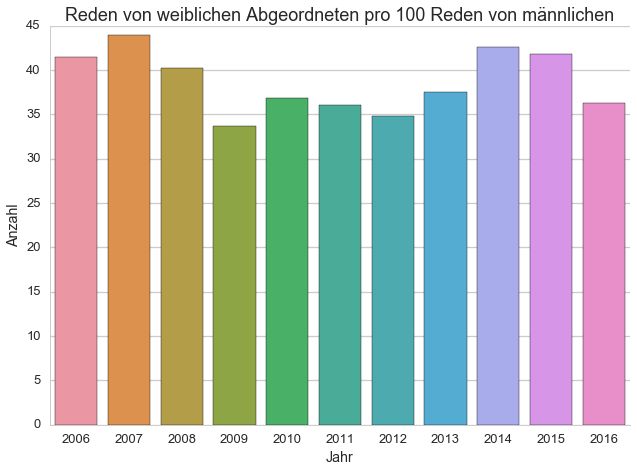

In [43]:
sns.set(context='talk', style='whitegrid')
sns.barplot(x='datum', y='Frau pro Mann', data=df_ratio.reset_index())
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Reden von weiblichen Abgeordneten pro 100 Reden von männlichen')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Anzahl')
sns.plt.savefig('geschlecht.svg')

# Parteien
Nun schauen wir uns die Parteien an. Hier sieht man 2 Einträge, ohne Partei. Das wird manuell korregiert.

Im Folgenden behandle ich Reden von Regierungsmitgliedern unter der virtuellen Partei 'Regierung'.

In [44]:
df.redner_partei.value_counts()

SPÖ                       7288
ÖVP                       6670
FPÖ                       5145
Grüne                     4398
BZÖ                       3301
Regierung                 1894
STRONACH                  1003
NEOS                       687
ohne Klubzugehörigkeit     227
Andere                     155
NEOS-LIF                    50
                             2
Name: redner_partei, dtype: int64

Manuelle Korrektur für 2 Fälle, in denen die Partei fehlt.

In [45]:
df.loc[df.redner_partei == '', ['redner_name', 'redner_partei']]

redner_name redner_partei
2249   Wolfgang Zanger              
20333       Peter Wurm

In [46]:
df.loc[(df.redner_partei == '') & (df.redner_name == 'Peter Wurm'), 'redner_partei'] = 'FPÖ'
df.loc[(df.redner_partei == '') & (df.redner_name == 'Wolfgang Zanger'), 'redner_partei'] = 'FPÖ'

In [47]:
df.loc[df.redner_partei == 'Andere', 'redner_anrede'].value_counts()

Präsident des Rechnungshofes            66
Volksanwältin                           19
Mitglied des Europäischen Parlaments    15
Berichterstatter                        14
Präsidentin                             14
Volksanwalt                             12
Präsident                                8
Berichterstatterin                       7
Name: redner_anrede, dtype: int64

In [48]:
# NEOS und NEOS-LIF im folgenden als eine Partei betrachtet 
df.loc[df.redner_partei == 'NEOS-LIF', 'redner_partei'] = 'NEOS'
# Behandle 'ohne Klubzugehörigkeit' und 'Andere' gemeinsam als 'Andere'. 
# Das ist eine Vereinfachung, da Fokus auf den Parteien und Regierung liegt.
df.loc[df.redner_partei == 'ohne Klubzugehörigkeit', 'redner_partei'] = 'Andere'

In [49]:
df.redner_partei.value_counts()

SPÖ          7288
ÖVP          6670
FPÖ          5147
Grüne        4398
BZÖ          3301
Regierung    1894
STRONACH     1003
NEOS          737
Andere        382
Name: redner_partei, dtype: int64

Definieren Reihenfolge der Parteien und zugehörige Farben.

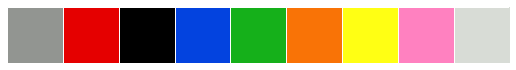

In [50]:
parteien_ordnung = ['Regierung', 
                    'SPÖ', 
                    'ÖVP', 
                    'FPÖ', 
                    'Grüne', 
                    'BZÖ',
                    'STRONACH',
                    'NEOS',
                    'Andere']

# Farbennamen von http://www.luminoso.com/colors/
parteien_farben = ['grey', #Regierung 
                   'red', 
                   'black', 
                   'blue', 
                   'green', 
                   'orange',
                   'yellow',
                   'pink', 
                   'light grey'] #Andere
sns.palplot(sns.xkcd_palette(parteien_farben))

In [51]:
df.groupby(['redner_partei', 'periode'])[['key']].count().unstack()

key                
periode         XXIII    XXIV     XXV
redner_partei                        
Andere           30.0   215.0   137.0
BZÖ             653.0  2648.0     NaN
FPÖ             890.0  3071.0  1186.0
Grüne           880.0  2517.0  1001.0
NEOS              NaN     NaN   737.0
Regierung       390.0  1076.0   428.0
SPÖ            1546.0  4130.0  1612.0
STRONACH          NaN   287.0   716.0
ÖVP            1568.0  3623.0  1479.0

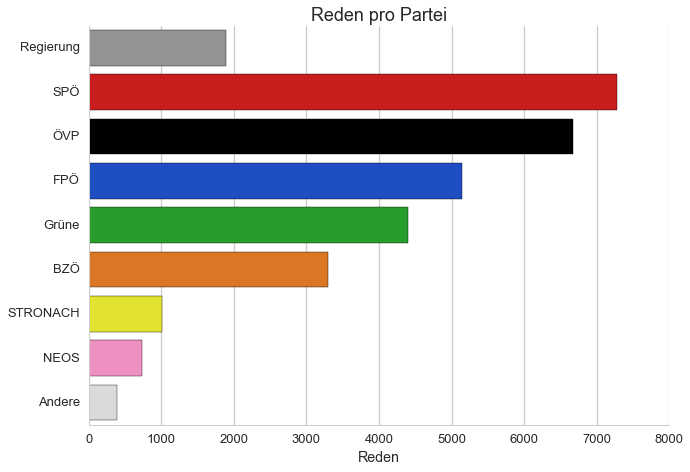

In [52]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.countplot(y='redner_partei', data=df, order=parteien_ordnung)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Reden pro Partei')
sns.set(font_scale=1)
sns.axlabel('Reden', '')
sns.plt.savefig('reden_pro_partei.svg')

Wie hat sich die relative Anzahl an Reden pro Partei über die Zeit verändert?

In [53]:
df_temp = df.groupby([df.datum.dt.year, 'redner_partei'])[['key']].count().unstack()
df_temp[:3]

key                                                      \
redner_partei Andere    BZÖ    FPÖ  Grüne NEOS Regierung    SPÖ STRONACH   
datum                                                                      
2006             3.0   45.0   65.0   61.0  NaN      20.0   84.0      NaN   
2007            13.0  337.0  447.0  466.0  NaN     205.0  856.0      NaN   
2008            14.0  328.0  446.0  407.0  NaN     188.0  666.0      NaN   

                      
redner_partei    ÖVP  
datum                 
2006            79.0  
2007           834.0  
2008           714.0

In [54]:
df_temp = df_temp.apply(lambda x: x / np.sum(x), axis=1) * 100
df_temp[:3]

key                                                  \
redner_partei    Andere        BZÖ        FPÖ      Grüne NEOS Regierung   
datum                                                                     
2006           0.840336  12.605042  18.207283  17.086835  NaN  5.602241   
2007           0.411653  10.671311  14.154528  14.756175  NaN  6.491450   
2008           0.506696  11.871155  16.141875  14.730366  NaN  6.804198   

                                              
redner_partei        SPÖ STRONACH        ÖVP  
datum                                         
2006           23.529412      NaN  22.128852  
2007           27.105763      NaN  26.409120  
2008           24.104235      NaN  25.841477

In [55]:
df_temp = df_temp.stack().reset_index()
df_temp = df_temp.rename(columns={'redner_partei': 'Partei'})
df_temp[:3]

datum  Partei        key
0   2006  Andere   0.840336
1   2006     BZÖ  12.605042
2   2006     FPÖ  18.207283

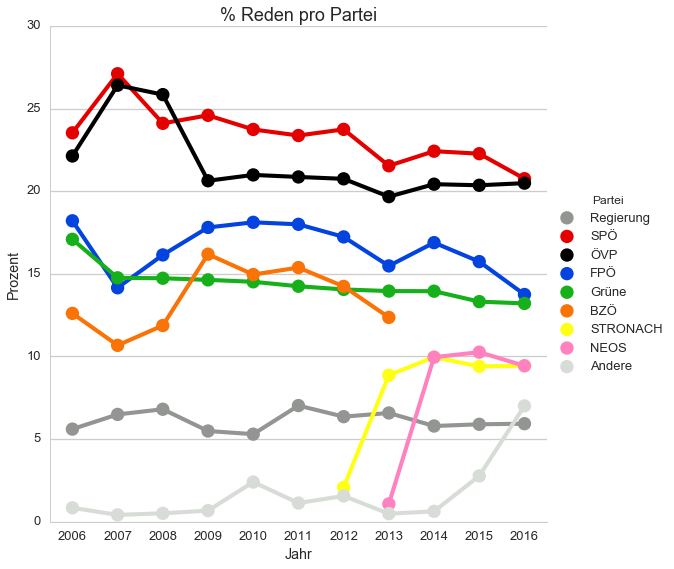

In [56]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.factorplot(x = 'datum', y = 'key', hue = 'Partei' , data = df_temp, size=8, hue_order=parteien_ordnung)
ax.set(ylim=(0, 30))
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('% Reden pro Partei')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Prozent')
sns.plt.savefig('reden_pro_partei_pro_jahr.svg')


Eine andere Darstellung der Verteilung der Reden pro Partei.

In [57]:
df_temp = (df.groupby([df.datum.dt.year, df.redner_partei])['key'].count()).unstack()
df_temp = df_temp[parteien_ordnung]
df_temp = df_temp.transpose()
mask = df_temp.isnull()
df_temp = df_temp.fillna(value=0)
df_temp = df_temp.astype('int')
df_temp[:13]

datum          2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
redner_partei                                                               
Regierung        20   205   188   237   181   255   208   190   203   185   
SPÖ              84   856   666  1062   811   848   777   622   786   699   
ÖVP              79   834   714   891   717   757   679   568   716   639   
FPÖ              65   447   446   769   619   653   564   447   592   494   
Grüne            61   466   407   632   496   517   460   403   489   418   
BZÖ              45   337   328   699   511   558   466   357     0     0   
STRONACH          0     0     0     0     0     0    68   256   349   295   
NEOS              0     0     0     0     0     0     0    31   349   322   
Andere            3    13    14    29    82    41    51    14    22    87   

datum          2016  
redner_partei        
Regierung        22  
SPÖ              77  
ÖVP              76  
FPÖ              51  
Grüne            49  
BZÖ               0  
STRONACH         35  
NEOS             35  
Andere           26

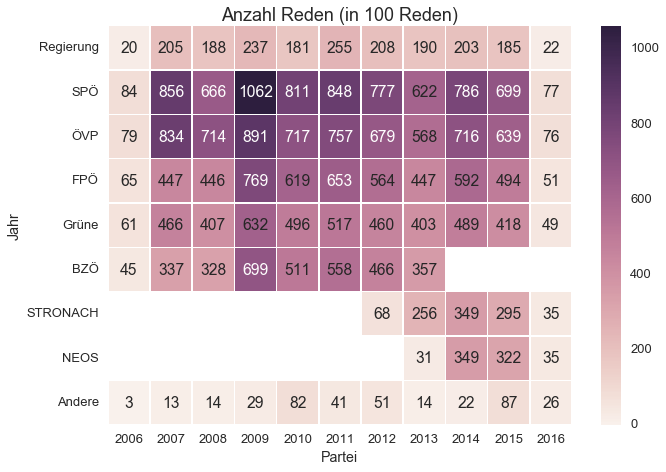

In [58]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.heatmap(df_temp, annot=True, linewidths=.5, fmt='d', mask=mask)
#sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Reden (in 100 Reden)')
sns.set(font_scale=1)
sns.axlabel('Partei', 'Jahr')
#sns.plt.savefig('geschlecht.svg')

Wie hat sich das Verhältnis der Reden von weiblichen Abgeordneten zu denen von männlichen pro Partei (exkl. Regierung) über die Zeit entwickelt?

In [59]:
df_ratio = df.groupby([df.datum.dt.year, 'redner_partei'])[['redner_anrede']].agg(lambda x: 
                                                               sum(x == 'Abgeordnete') / sum(x == 'Abgeordneter')*100)
df_ratio = df_ratio.reset_index()
df_ratio = df_ratio.rename(columns={'redner_partei': 'Partei', 'redner_anrede': 'Rednerin pro Redner'})

df_ratio = df_ratio.loc[df_ratio.Partei != 'Regierung']
df_ratio[:3]

datum  Partei  Rednerin pro Redner
0   2006  Andere                  NaN
1   2006     BZÖ            15.384615
2   2006     FPÖ            12.068966

In [60]:
parteien_ordnung_ohne_regierung = parteien_ordnung.copy()
parteien_ordnung_ohne_regierung.remove('Regierung')
parteien_farben_ohne_regierung = parteien_farben.copy()
parteien_farben_ohne_regierung.remove('grey')

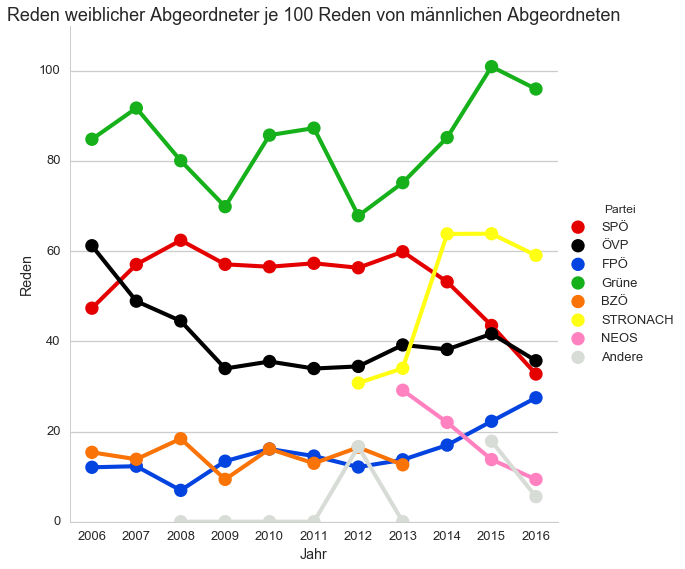

In [62]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben_ohne_regierung))

ax = sns.factorplot(x = 'datum', y = 'Rednerin pro Redner', hue = 'Partei' , data = df_ratio, size=8, 
                    hue_order=parteien_ordnung_ohne_regierung)
ax.set(ylim=(0, 110))
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Reden weiblicher Abgeordneter je 100 Reden von männlichen Abgeordneten')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Reden')
sns.plt.savefig('geschlecht_je_partei.svg')

Wie ist z.B. der Rückgang bei den NEOS zu erklären?

In [63]:
df[df.redner_partei == 'NEOS'].groupby([df.datum.dt.year, 'redner_anrede', 'redner_name'])[['key']].count().unstack('datum')

key                 
datum                                         2013  2014  2015 2016
redner_anrede redner_name                                          
Abgeordnete   Claudia Angela Gamon, MSc (WU)   NaN   NaN   6.0  3.0
              Mag. Beate Meinl-Reisinger, MES  4.0  50.0  33.0  NaN
              Mag. Dr. Angelika Rosa Mlinar    3.0  13.0   NaN  NaN
Abgeordneter  Dr. Nikolaus Scherak             1.0  32.0  57.0  6.0
              Dr. Rainer Hable                 8.0  55.0  19.0  1.0
              Josef Schellhorn                 NaN  21.0  34.0  4.0
              Mag. Christoph Vavrik            1.0  13.0  15.0  NaN
              Mag. Dr. Matthias Strolz         6.0  53.0  41.0  6.0
              Mag. Gerald Loacker              4.0  55.0  54.0  9.0
              Mag. Nikolaus Alm                1.0  24.0  26.0  4.0
              Mag. Nikolaus Scherak            2.0   NaN   NaN  NaN
              Michael Pock                     1.0  33.0  37.0  2.0

In [65]:
df[df.redner_partei == 'STRONACH'].groupby([df.datum.dt.year, 'redner_anrede', 'redner_name'])[['key']].count().unstack('datum')

key                       
datum                                         2012  2013  2014  2015 2016
redner_anrede redner_name                                                
Abgeordnete   Dr. Jessi Lintl                  NaN   NaN  13.0  11.0  NaN
              Dr. Kathrin Nachbaur             NaN   7.0  51.0  18.0  NaN
              Elisabeth Kaufmann-Bruckberger  16.0  16.0   NaN   NaN  NaN
              Ing. Waltraud Dietrich           NaN   5.0  36.0  41.0  4.0
              Martina Schenk                   NaN  37.0  22.0  29.0  6.0
              Ulrike Weigerstorfer             NaN   NaN  14.0  16.0  3.0
Abgeordneter  Christoph Hagen                 21.0  65.0  35.0  47.0  7.0
              Dr. Georg Vetter                 NaN   9.0  42.0  12.0  NaN
              Dr. Marcus Franz                 NaN   3.0  34.0  10.0  NaN
              Erich Tadler                     3.0  18.0   NaN   NaN  NaN
              Frank Stronach                   NaN   2.0   1.0   NaN  NaN
              Ing. Robert Lugar               17.0  51.0  38.0  48.0  9.0
              Leopold Steinbichler             NaN   5.0  41.0  46.0  6.0
              Rouven Ertlschweiger, MSc        NaN   NaN  22.0  17.0  NaN
              Stefan Markowitz                11.0  38.0   NaN   NaN  NaN

# Länge der Reden

In [66]:
# from http://stackoverflow.com/questions/17507876/trying-to-count-words-in-a-string
def anzahl_woerter(txt):
    return len(re.findall(r'\b\w+\b', txt))

In [67]:
anzahl_woerter('Johnny.Appleseed!is:a*good&farmer')

6

In [68]:
%%time
df['rede_anzahl_woerter'] = df.rede_txt.apply(anzahl_woerter)

Wall time: 8.65 s


In [69]:
df[:3]

datum                 key periode  \
0 2007-07-05  XXIII_NRSITZ_00028   XXIII   
1 2007-07-05  XXIII_NRSITZ_00028   XXIII   
2 2007-07-05  XXIII_NRSITZ_00028   XXIII   

                                                rede  \
0  Abgeordneter Dr. Peter Pilz (Grüne): Frau Präs...   
1  Abgeordneter Dr. Günther Kräuter (SPÖ): Sehr g...   
2  Abgeordneter Heinz-Christian Strache (FPÖ): Se...   

                                             sitzung  \
0  28. Sitzung des\r\nNationalrates der Republik ...   
1  28. Sitzung des\r\nNationalrates der Republik ...   
2  28. Sitzung des\r\nNationalrates der Republik ...   

                                            rede_txt redner_anrede  \
0  Frau Präsidentin! Meine sehr verehrten Damen u...  Abgeordneter   
1  Sehr geehrte Frau Präsidentin! Herr Bundesmini...  Abgeordneter   
2  Sehr geehrte Frau Präsidentin! Sehr geehrter H...  Abgeordneter   

               redner_name redner_partei  rede_anzahl_woerter  
0           Dr. Peter Pilz         Grüne                 1743  
1      Dr. Günther Kräuter           SPÖ                 1051  
2  Heinz-Christian Strache           FPÖ                 2044

In [70]:
df_temp = (df.groupby(df.datum.dt.year)
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp[:3]

woerter  reden  woerter_pro_rede
datum                                  
2006    228325    357        639.565826
2007   1914967   3158        606.386004
2008   1531344   2763        554.232356

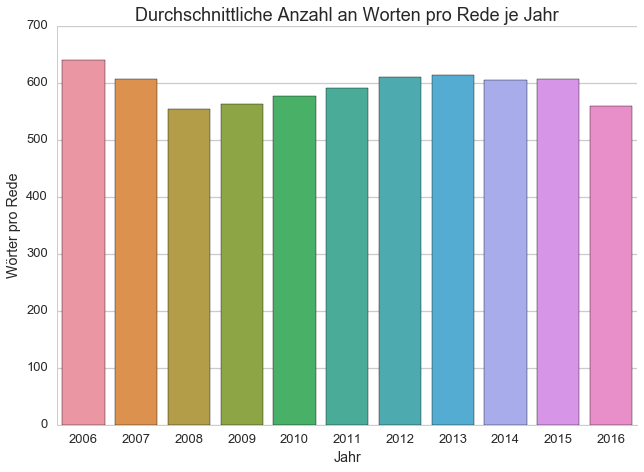

In [71]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.barplot(x='datum', y='woerter_pro_rede', data=df_temp.reset_index())
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Anzahl an Worten pro Rede je Jahr')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Wörter pro Rede')
sns.plt.savefig('woerter_pro_rede_je_jahr.svg')

In [72]:
df_temp = (df.groupby('redner_partei')
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp[:3]

woerter  reden  woerter_pro_rede
redner_partei                                  
Andere          264319    382        691.934555
BZÖ            2214068   3301        670.726447
FPÖ            3264382   5147        634.230037

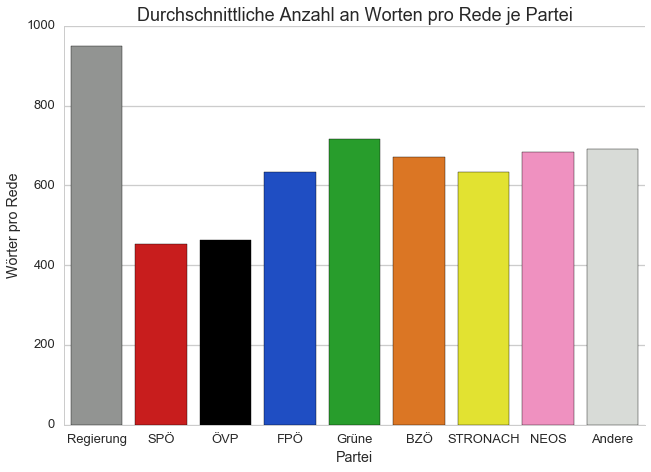

In [73]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.barplot(x='redner_partei', y='woerter_pro_rede', data=df_temp.reset_index(), order=parteien_ordnung)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Anzahl an Worten pro Rede je Partei')
sns.set(font_scale=1)
sns.axlabel('Partei', 'Wörter pro Rede')
sns.plt.savefig('woerter_pro_rede_je_partei.svg')

In [74]:
df_temp = (df.groupby([df.datum.dt.year, 'redner_partei'])
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp = df_temp.woerter_pro_rede
df_temp = df_temp.unstack()
df_temp = df_temp / 100
df_temp = df_temp[parteien_ordnung]
df_temp = df_temp.transpose()
df_temp[:3]

datum              2006       2007      2008      2009      2010      2011  \
redner_partei                                                                
Regierung      9.391000  11.010146  8.871117  9.293797  9.777956  8.756353   
SPÖ            5.639405   4.340479  4.421877  4.239689  4.433662  4.677441   
ÖVP            5.384051   4.149580  4.015714  4.644961  4.617238  4.767503   

datum              2012      2013       2014      2015      2016  
redner_partei                                                     
Regierung      9.385240  8.544526  10.221330  9.871946  7.312727  
SPÖ            4.614363  4.818955   4.607774  4.690973  4.569870  
ÖVP            5.004050  4.872518   4.784330  4.864679  4.488947

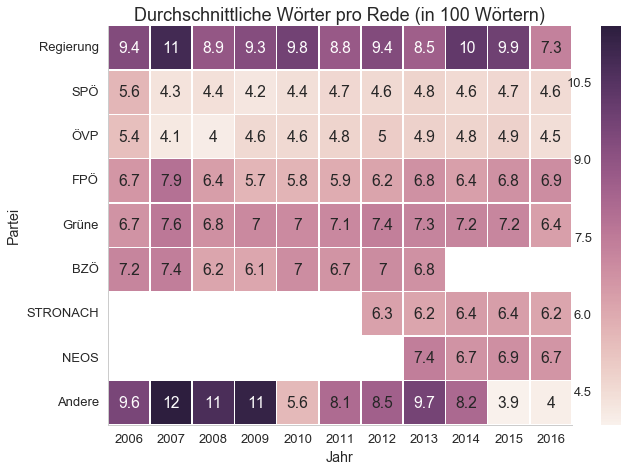

In [75]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.heatmap(df_temp, annot=True, linewidths=.5)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Wörter pro Rede (in 100 Wörtern)')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Partei')
#sns.plt.savefig('geschlecht.svg')

In [76]:
df.sort_values(by='rede_anzahl_woerter', ascending=False)[:10]

datum                 key periode  \
9704  2009-07-10   XXIV_NRSITZ_00032    XXIV   
7980  2011-10-20   XXIV_NRSITZ_00124    XXIV   
5041  2010-11-30   XXIV_NRSITZ_00086    XXIV   
9488  2009-04-21   XXIV_NRSITZ_00019    XXIV   
10382 2014-04-29    XXV_NRSITZ_00021     XXV   
15139 2007-03-29  XXIII_NRSITZ_00017   XXIII   
5222  2012-10-16   XXIV_NRSITZ_00173    XXIV   
26027 2015-10-14    XXV_NRSITZ_00096     XXV   
3022  2007-01-17  XXIII_NRSITZ_00009   XXIII   
925   2008-12-03   XXIV_NRSITZ_00006    XXIV   

                                                    rede  \
9704   Berichterstatter Jakob Auer: Herr Präsident! M...   
7980   Bundesministerin für Finanzen Mag. Dr. Maria T...   
5041   Bundesminister für Finanzen Vizekanzler Dipl.-...   
9488   Bundesminister für Finanzen Vizekanzler Dipl.-...   
10382  Bundesminister für Finanzen Vizekanzler Dr. Mi...   
15139  Bundesminister für Finanzen Vizekanzler Mag. W...   
5222   Bundesministerin für Finanzen Mag. Dr. Maria T...   
26027  Bundesminister für Finanzen Dr. Johann Georg S...   
3022   Bundeskanzler Dr. Alfred Gusenbauer: Sehr vere...   
925    Abgeordneter Fritz Neugebauer (ÖVP): Ich danke...   

                                                 sitzung  \
9704   32. Sitzung des\r\nNationalrates der Republik ...   
7980   124. Sitzung des\r\nNationalrates der Republik...   
5041   86. Sitzung des\r\nNationalrates der Republik ...   
9488   19. Sitzung des\r\nNationalrates der Republik ...   
10382  21. Sitzung des\r\nNationalrates der Republik ...   
15139  17. Sitzung des Nationalrates der Republik Öst...   
5222   173. Sitzung des\r\nNationalrates der Republik...   
26027  96. Sitzung des\r\nNationalrates der Republik ...   
3022   9. Sitzung des Nationalrates der Republik Öste...   
925    6. Sitzung des Nationalrates\r\nder Republik Ö...   

                                                rede_txt  \
9704   Herr Präsident! Meine sehr verehrten Damen und...   
7980   Sehr geehrter Herr Bundespräsident! Sehr geehr...   
5041   Sehr geehrter Herr Bundespräsident! Frau Präsi...   
9488   Sehr geehrter Herr Bundespräsident! Frau Präsi...   
10382  Sehr geschätzter Herr Bundespräsident! Frau Pr...   
15139  Grüß Gott, meine Damen und Herren! Sehr geehrt...   
5222   Stabile Finanzen durch Reformen, Wachstum durc...   
26027  Liebe Österreicherinnen und Österreicher! Gesc...   
3022   Sehr verehrter Herr Bundespräsident! Frau Präs...   
925    Ich danke für die Zustimmung und nehme die Wah...   

                                 redner_anrede  \
9704                          Berichterstatter   
7980             Bundesministerin für Finanzen   
5041   Bundesminister für Finanzen Vizekanzler   
9488   Bundesminister für Finanzen Vizekanzler   
10382  Bundesminister für Finanzen Vizekanzler   
15139  Bundesminister für Finanzen Vizekanzler   
5222             Bundesministerin für Finanzen   
26027              Bundesminister für Finanzen   
3022                             Bundeskanzler   
925                               Abgeordneter   

                          redner_name redner_partei  rede_anzahl_woerter  
9704                       Jakob Auer        Andere                 9546  
7980   Mag. Dr. Maria Theresia Fekter     Regierung                 8508  
5041           Dipl.-Ing. Josef Pröll     Regierung                 8201  
9488           Dipl.-Ing. Josef Pröll     Regierung                 7760  
10382        Dr. Michael Spindelegger     Regierung                 7580  
15139           Mag. Wilhelm Molterer     Regierung                 7154  
5222   Mag. Dr. Maria Theresia Fekter     Regierung                 7058  
26027      Dr. Johann Georg Schelling     Regierung                 7013  
3022            Dr. Alfred Gusenbauer     Regierung                 6669  
925                  Fritz Neugebauer           ÖVP                 5958

In [77]:
df_temp = df.groupby([df.datum.dt.year, 'redner_partei'])[['rede_anzahl_woerter']].sum().unstack()

df_temp = df_temp.apply(lambda x: x / np.sum(x), axis=1) * 100

df_temp = df_temp.stack().reset_index()
df_temp = df_temp.rename(columns={'redner_partei': 'Partei', '0': 'rede_anzahl_woerter'})
df_temp[:3]

datum  Partei  rede_anzahl_woerter
0   2006  Andere             1.263112
1   2006     BZÖ            14.180664
2   2006     FPÖ            18.936166

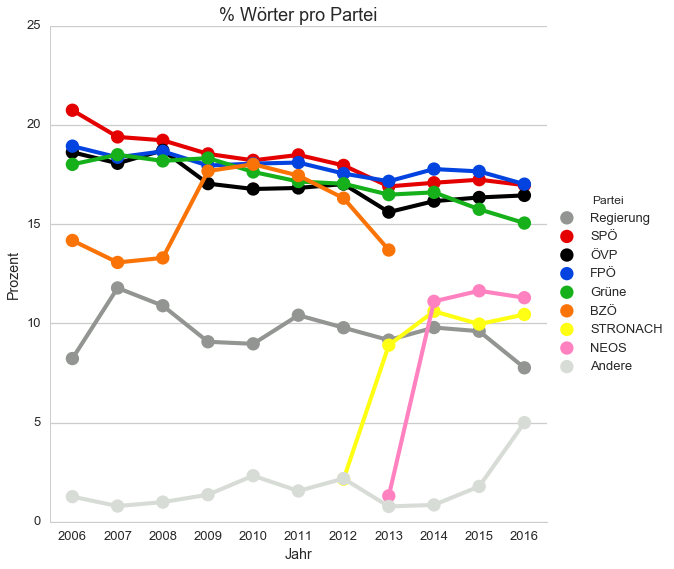

In [78]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))

ax = sns.factorplot(x = 'datum', y = 'rede_anzahl_woerter', hue = 'Partei' , data = df_temp, size=8, 
                    hue_order=parteien_ordnung)
ax.set(ylim=(0, 25))
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('% Wörter pro Partei')
sns.set(font_scale=1)
sns.axlabel('Jahr', 'Prozent')
sns.plt.savefig('woerter_pro_partei_je_jahr.svg')


In [79]:
df_temp = (df.groupby([df.datum.dt.year, df.redner_partei])['rede_anzahl_woerter'].sum()).unstack()
df_temp = df_temp[parteien_ordnung]
df_temp = df_temp.transpose()
mask = df_temp.isnull()
df_temp = df_temp.fillna(value=0)
df_temp = round(df_temp / 10000)
df_temp = df_temp.astype('int')
df_temp[:13]

datum          2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
redner_partei                                                               
Regierung         2    23    17    22    18    22    20    16    21    18   
SPÖ               5    37    29    45    36    40    36    30    36    33   
ÖVP               4    35    29    41    33    36    34    28    34    31   
FPÖ               4    35    29    44    36    39    35    30    38    34   
Grüne             4    35    28    45    35    37    34    29    35    30   
BZÖ               3    25    20    43    36    37    33    24     0     0   
STRONACH          0     0     0     0     0     0     4    16    22    19   
NEOS              0     0     0     0     0     0     0     2    24    22   
Andere            0     2     2     3     5     3     4     1     2     3   

datum          2016  
redner_partei        
Regierung         2  
SPÖ               4  
ÖVP               3  
FPÖ               4  
Grüne             3  
BZÖ               0  
STRONACH          2  
NEOS              2  
Andere            1

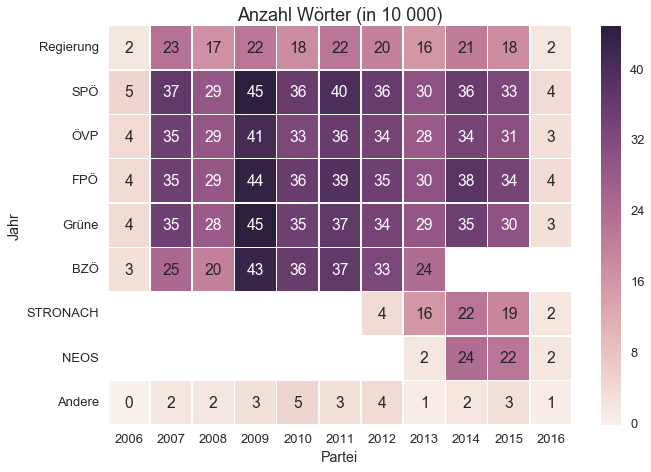

In [80]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.heatmap(df_temp, annot=True, linewidths=.5, fmt='d', mask=mask)
#sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Anzahl Wörter (in 10 000)')
sns.set(font_scale=1)
sns.axlabel('Partei', 'Jahr')
#sns.plt.savefig('geschlecht.svg')

In [81]:
df_temp = (df.groupby(df.datum.dt.month)
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp[:3]

woerter  reden  woerter_pro_rede
datum                                  
1      1451522   2399        605.052939
2       948267   1569        604.376673
3      1844419   3118        591.539128

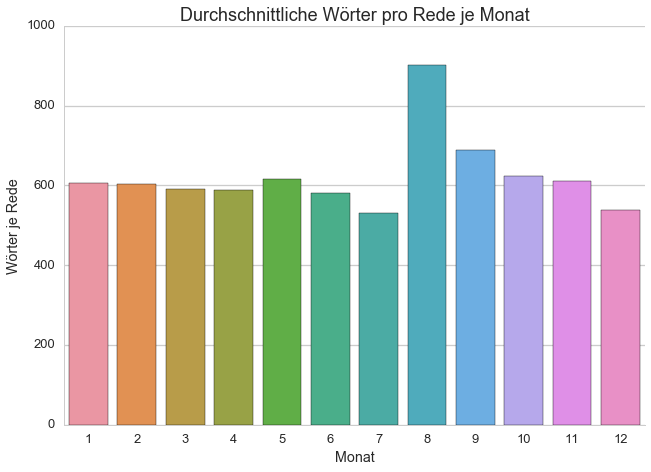

In [82]:
sns.set(context='talk', style='whitegrid')
sns.barplot(x='datum', y='woerter_pro_rede', data=df_temp.reset_index())
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Wörter pro Rede je Monat')
sns.set(font_scale=1)
sns.axlabel('Monat', 'Wörter je Rede')
#sns.plt.savefig('geschlecht.svg')

In [83]:
df_temp = (df.groupby([df.datum.dt.month, df.datum.dt.year])
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp = df_temp.woerter_pro_rede
df_temp = df_temp.unstack()
df_temp = df_temp / 100
df_temp[:3]

datum  2006      2007      2008      2009      2010      2011      2012  \
datum                                                                     
1       NaN  7.631205  5.632826  6.441859  5.539053  5.275805  6.136543   
2       NaN       NaN       NaN  4.769273  6.194412  9.291200  6.283447   
3       NaN  6.475766  5.470185  4.990970  5.759085  6.186834  5.779534   

datum      2013      2014      2015      2016  
datum                                          
1      5.756801  5.433277  6.967581  5.909652  
2      6.452460  7.005679  5.728421  5.209588  
3      5.672059  6.402978  6.566250       NaN

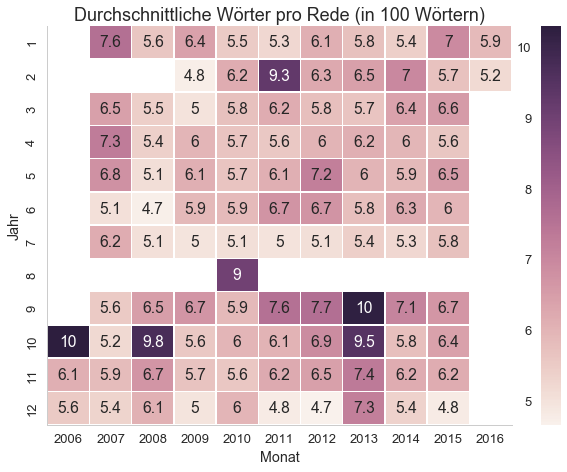

In [84]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.heatmap(df_temp, annot=True, linewidths=.5)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Wörter pro Rede (in 100 Wörtern)')
sns.set(font_scale=1)
sns.axlabel('Monat', 'Jahr')
#sns.plt.savefig('geschlecht.svg')

In [85]:
df_temp = (df.groupby(df.datum.dt.dayofweek)
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp[:3]

woerter  reden  woerter_pro_rede
datum                                  
0       359142    408        880.250000
1      2583637   4030        641.100993
2      6304870  10512        599.778349

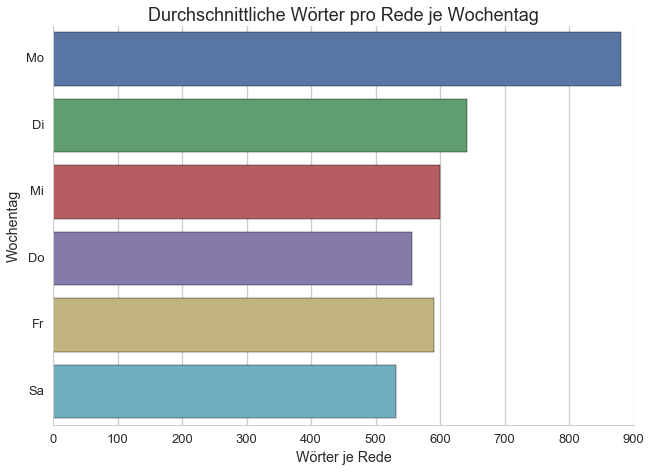

In [86]:
sns.set(context='talk', style='whitegrid')
ax = sns.barplot(y='datum', x='woerter_pro_rede', data=df_temp.reset_index(), orient='h')
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Wörter pro Rede je Wochentag')
sns.set(font_scale=1)
sns.axlabel('Wörter je Rede', 'Wochentag')
labels = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa']
ax.set_yticklabels(labels)
sns.plt.savefig('woerter_pro_wochentag.svg')

In [87]:
df_temp = (df.groupby([df.datum.dt.dayofweek, df.datum.dt.month])
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp = df_temp.woerter_pro_rede
df_temp = df_temp.unstack()
df_temp = df_temp / 100
df_temp.index = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa']
df_temp[:3]

datum        1         2         3          4          5         6         7   \
Mo          NaN  7.500510  8.205641  11.145172  10.253333  9.475714       NaN   
Di     6.258969  6.939865  6.970000   6.220626   6.744286  5.200458  5.587575   
Mi     6.879826  5.657642  6.314768   6.034325   6.004242  6.200072  5.150375   

datum        8         9          10        11        12  
Mo          NaN       NaN  10.499474       NaN       NaN  
Di          NaN  8.563448   7.280685  5.812907  5.925711  
Mi     9.020833  6.674188   6.255066  5.834187  5.507077

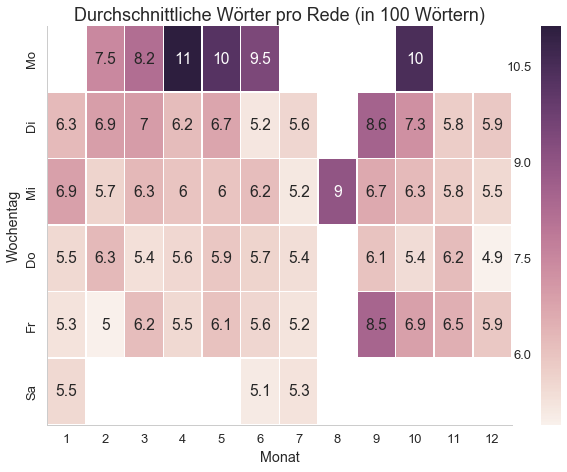

In [88]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
sns.heatmap(df_temp, annot=True, linewidths=.5)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Durchschnittliche Wörter pro Rede (in 100 Wörtern)')
sns.set(font_scale=1)
sns.axlabel('Monat', 'Wochentag')
#sns.plt.savefig('geschlecht.svg')

In [89]:
df_temp = (df[df.redner_anrede.isin(['Abgeordnete', 'Abgeordneter'])].groupby(['redner_anrede'])
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp = df_temp.reset_index().rename(columns={'redner_anrede': 'Redner'})
df_temp[:13]

Redner   woerter  reden  woerter_pro_rede
0   Abgeordnete   4118454   7968        516.874247
1  Abgeordneter  12151490  20803        584.122002

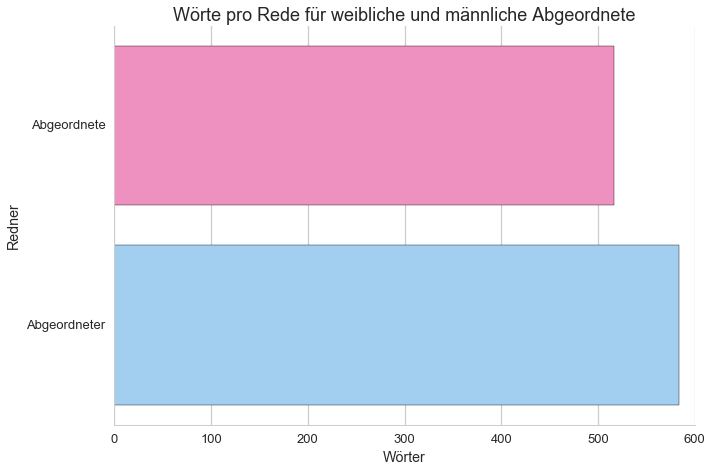

In [90]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(['pink', 'light blue']))

ax = sns.barplot(x='woerter_pro_rede', y = 'Redner' , data = df_temp)
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Wörte pro Rede für weibliche und männliche Abgeordnete')
sns.set(font_scale=1)
sns.axlabel('Wörter', 'Redner')
#sns.plt.savefig('geschlecht.svg')


In [91]:
df_temp = (df[df.redner_anrede.isin(['Abgeordnete', 'Abgeordneter'])].groupby(['redner_partei', 'redner_anrede'])
            .agg({'rede_anzahl_woerter': 'sum', 'key': 'count'})
            .rename(columns={'rede_anzahl_woerter': 'woerter', 'key': 'reden'}))
df_temp['woerter_pro_rede'] = df_temp['woerter'] / df_temp['reden']
df_temp = df_temp.reset_index().rename(columns={'redner_anrede': 'Redner'})
df_temp[:13]

redner_partei        Redner  woerter  reden  woerter_pro_rede
0         Andere   Abgeordnete     8076     16        504.750000
1         Andere  Abgeordneter   104681    211        496.118483
2            BZÖ   Abgeordnete   235753    399        590.859649
3            BZÖ  Abgeordneter  1978315   2902        681.707443
4            FPÖ   Abgeordnete   367174    647        567.502318
5            FPÖ  Abgeordneter  2897208   4500        643.824000
6          Grüne   Abgeordnete  1337864   1980        675.688889
7          Grüne  Abgeordneter  1812393   2418        749.542184
8           NEOS   Abgeordnete    77864    112        695.214286
9           NEOS  Abgeordneter   425448    625        680.716800
10           SPÖ   Abgeordnete  1084493   2599        417.273182
11           SPÖ  Abgeordneter  2218925   4689        473.219237
12      STRONACH   Abgeordnete   207047    345        600.136232

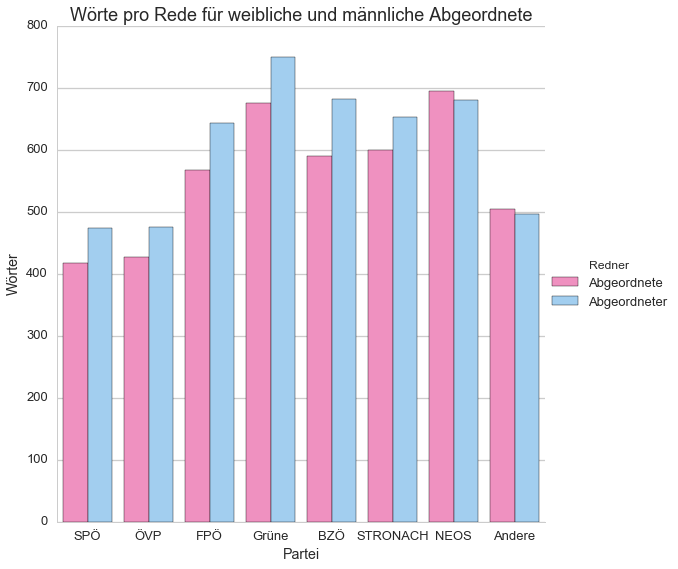

In [92]:
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(['pink', 'light blue']))

ax = sns.factorplot(x = 'redner_partei', y = 'woerter_pro_rede', hue = 'Redner' , data = df_temp, size=8, 
                    kind='bar', order=parteien_ordnung_ohne_regierung)
#ax.set(ylim=(0, 1.2))
sns.despine()
sns.set(font_scale=1.5)
sns.plt.title('Wörte pro Rede für weibliche und männliche Abgeordnete')
sns.set(font_scale=1)
sns.axlabel('Partei', 'Wörter')
sns.plt.savefig('woerter_pro_geschlecht_je_partei.svg')


# Einzelne Redner

In [93]:
df.redner_name.value_counts()

Mag. Werner Kogler                                                                                            394
Herbert Scheibner                                                                                             354
Heinz-Christian Strache                                                                                       317
Dr. Josef Cap                                                                                                 314
Ing. Robert Lugar                                                                                             297
Ursula Haubner                                                                                                285
Ing. Peter Westenthaler                                                                                       284
Karl Öllinger                                                                                                 279
Christoph Hagen                                                                         

In [94]:
df.loc[df.redner_name.str.contains('Alois Stöger'), 'redner_name'].value_counts()

Alois Stöger, diplômé    87
Alois Stöger, dipl.       1
Alois Stöger              1
Name: redner_name, dtype: int64

In [95]:
df.loc[df.redner_name.str.contains('Alois Stöger'), 'redner_name'] = 'Alois Stöger, diplômé'

In [96]:
df.loc[df.redner_name.str.contains('Andrä Rupprechter'), 'redner_name'].value_counts()

Dipl.-Ing. Andrä Rupprechter     41
Dipl.- Ing. Andrä Rupprechter     1
Name: redner_name, dtype: int64

In [97]:
df.loc[df.redner_name.str.contains('Andrä Rupprechter'), 'redner_name'] = 'Dipl.-Ing. Andrä Rupprechter'

In [98]:
df.loc[df.redner_name.str.contains('Reinhold Mitterlehner'), 'redner_name'].value_counts()

Dr. Reinhold Mitterlehner                                                                                     150
, betraut mit der Leitung des Bundesministeriums für Wissenschaft und Forschung, Dr. Reinhold Mitterlehner      2
Dr. Reinhold Mitterlehner, betraut mit der Leitung des Bundesministeriums für Wissenschaft und Forschung        1
Name: redner_name, dtype: int64

In [99]:
df.loc[df.redner_name.str.contains('Reinhold Mitterlehner'), 'redner_name'] = 'Dr. Reinhold Mitterlehner'

In [100]:
df.loc[df.redner_name.str.contains('Johannes Hahn'), 'redner_name'].value_counts()

Dr. Johannes Hahn                                                               25
Dr. Johannes Hahn, betraut mit der Leitung des Bundesministeriums für Justiz     2
Name: redner_name, dtype: int64

In [101]:
df.loc[df.redner_name.str.contains('Johannes Hahn'), 'redner_name'] = 'Dr. Johannes Hahn'

In [102]:
df.redner_name.value_counts()

Mag. Werner Kogler                    394
Herbert Scheibner                     354
Heinz-Christian Strache               317
Dr. Josef Cap                         314
Ing. Robert Lugar                     297
Ursula Haubner                        285
Ing. Peter Westenthaler               284
Karl Öllinger                         279
Christoph Hagen                       277
Josef Bucher                          267
Sigisbert Dolinschek                  259
Dr. Walter Rosenkranz                 259
Dipl.-Ing. Dr. Wolfgang Pirklhuber    257
Dr. Gabriela Moser                    256
Mag. Albert Steinhauser               247
Dr. Dagmar Belakowitsch-Jenewein      240
Gerald Grosz                          233
Mag. Ewald Stadler                    228
Kai Jan Krainer                       228
Otto Pendl                            228
Dr. Peter Fichtenbauer                204
Martina Schenk                        204
Dr. Christoph Matznetter              202
Ing. Norbert Hofer                

In [103]:
df[:3]

datum                 key periode  \
0 2007-07-05  XXIII_NRSITZ_00028   XXIII   
1 2007-07-05  XXIII_NRSITZ_00028   XXIII   
2 2007-07-05  XXIII_NRSITZ_00028   XXIII   

                                                rede  \
0  Abgeordneter Dr. Peter Pilz (Grüne): Frau Präs...   
1  Abgeordneter Dr. Günther Kräuter (SPÖ): Sehr g...   
2  Abgeordneter Heinz-Christian Strache (FPÖ): Se...   

                                             sitzung  \
0  28. Sitzung des\r\nNationalrates der Republik ...   
1  28. Sitzung des\r\nNationalrates der Republik ...   
2  28. Sitzung des\r\nNationalrates der Republik ...   

                                            rede_txt redner_anrede  \
0  Frau Präsidentin! Meine sehr verehrten Damen u...  Abgeordneter   
1  Sehr geehrte Frau Präsidentin! Herr Bundesmini...  Abgeordneter   
2  Sehr geehrte Frau Präsidentin! Sehr geehrter H...  Abgeordneter   

               redner_name redner_partei  rede_anzahl_woerter  
0           Dr. Peter Pilz         Grüne                 1743  
1      Dr. Günther Kräuter           SPÖ                 1051  
2  Heinz-Christian Strache           FPÖ                 2044

In [104]:
df = df.drop('rede', axis=1)

# Wordcloud

## Rede von Sonderzeichen befreien

In [105]:
import string

In [106]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [107]:
translator = str.maketrans({key: None for key in string.punctuation})

In [109]:
df['rede_clean'] = df.rede_txt.str.translate(translator)

In [110]:
#df.to_pickle('df_03.pkl')

## Tatsächliche Wordclouds erzeugen

In [111]:
from wordcloud import WordCloud

# https://github.com/amueller/word_cloud
# Achtung, ich habe an der Erweiterung wordcloud - die für englische Sprache entwickelt wurde - etwas 
# herumgebastelt, um zu verhindern, dass ein 's' am Ende eines Worts als Pluar interpretiert wird. 
# Ansonst würden zum Beispiel die Wörter hau und Haus zusammen erfasst.

import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
#df = pd.read_pickle('df_03.pkl')

In [113]:
df[:3]

datum                 key periode  \
0 2007-07-05  XXIII_NRSITZ_00028   XXIII   
1 2007-07-05  XXIII_NRSITZ_00028   XXIII   
2 2007-07-05  XXIII_NRSITZ_00028   XXIII   

                                             sitzung  \
0  28. Sitzung des\r\nNationalrates der Republik ...   
1  28. Sitzung des\r\nNationalrates der Republik ...   
2  28. Sitzung des\r\nNationalrates der Republik ...   

                                            rede_txt redner_anrede  \
0  Frau Präsidentin! Meine sehr verehrten Damen u...  Abgeordneter   
1  Sehr geehrte Frau Präsidentin! Herr Bundesmini...  Abgeordneter   
2  Sehr geehrte Frau Präsidentin! Sehr geehrter H...  Abgeordneter   

               redner_name redner_partei  rede_anzahl_woerter  \
0           Dr. Peter Pilz         Grüne                 1743   
1      Dr. Günther Kräuter           SPÖ                 1051   
2  Heinz-Christian Strache           FPÖ                 2044   

                                          rede_clean  
0  Frau Präsidentin Meine sehr verehrten Damen un...  
1  Sehr geehrte Frau Präsidentin Herr Bundesminis...  
2  Sehr geehrte Frau Präsidentin Sehr geehrter He...

In [115]:
#stopword Liste 1 von http://members.unine.ch/jacques.savoy/clef/index.html
STOPWORDS_GENERAL = set([x.strip() for x in open('germanST.txt').read().split('\n')])
STOPWORDS_GENERAL = STOPWORDS_GENERAL.union(set(('nämlich',)))

#stopword Liste 2 von https://solariz.de/de/downloads/6/german-enhanced-stopwords.htm
#STOPWORDS_GENERAL = set([x.strip() for x in open('stopwords_2.txt').read().split('\n')])

In [116]:
len(STOPWORDS_GENERAL)

580

In [117]:
def wc(df_temp, titel=None, dateiname=False):
    text = ' '.join(df_temp)
    # take relative word frequencies into account, lower max_font_size
    # wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5, background_color='white', 
                          scale=3, random_state=42,
                          stopwords = STOPWORDS_GENERAL).generate(text)
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    if titel:
        plt.title(titel)
    plt.show()
    if dateiname:
        wordcloud.to_file(dateiname)

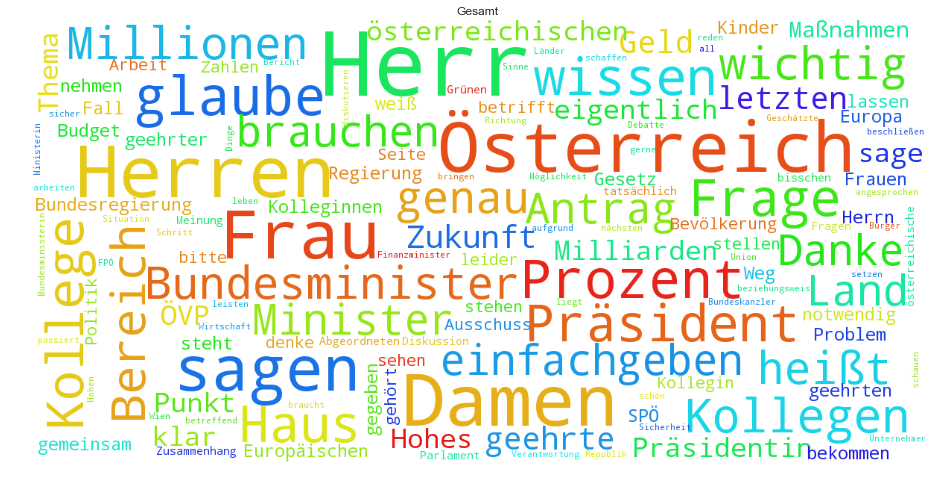

In [118]:
wc(df.rede_clean, titel='Gesamt', dateiname='wc_gesamt.png')

In [119]:
#for periode in df.periode.unique():
#    wc(df.loc[df.periode == periode, 'rede_clean'], titel=periode)

In [120]:
df.redner_partei.value_counts()

SPÖ          7288
ÖVP          6670
FPÖ          5147
Grüne        4398
BZÖ          3301
Regierung    1894
STRONACH     1003
NEOS          737
Andere        382
Name: redner_partei, dtype: int64

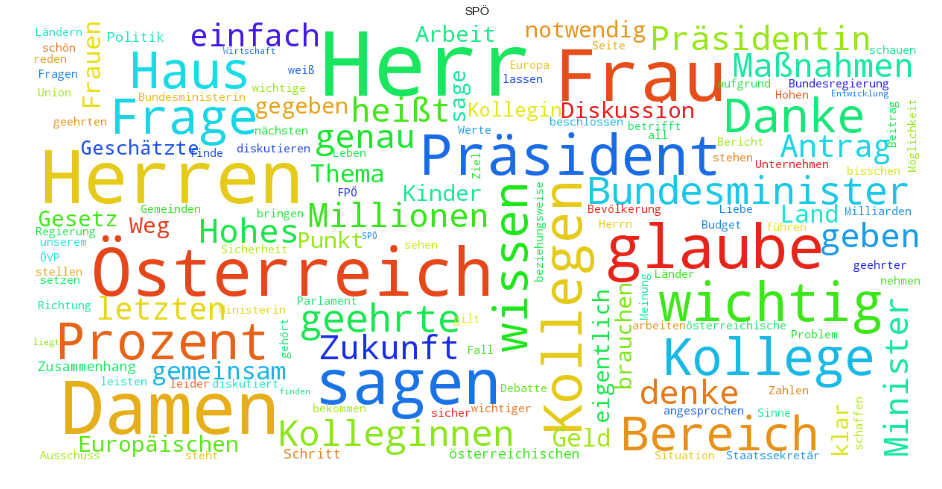

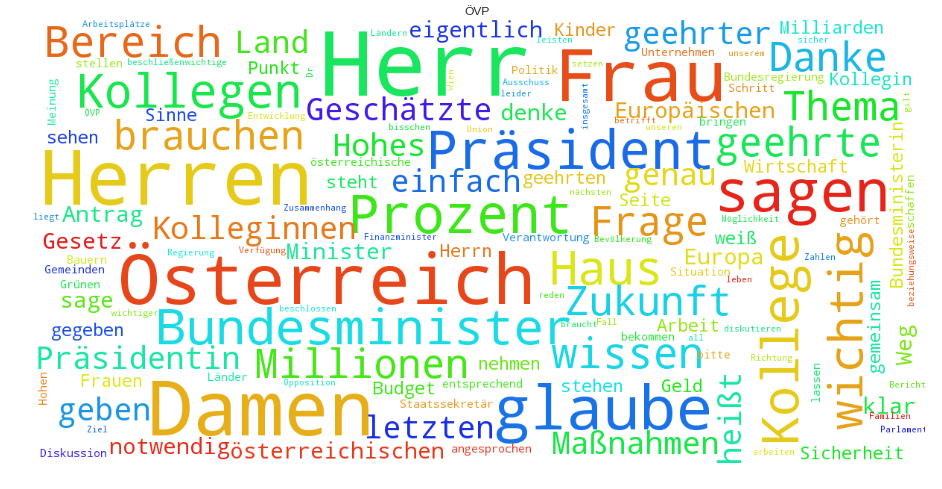

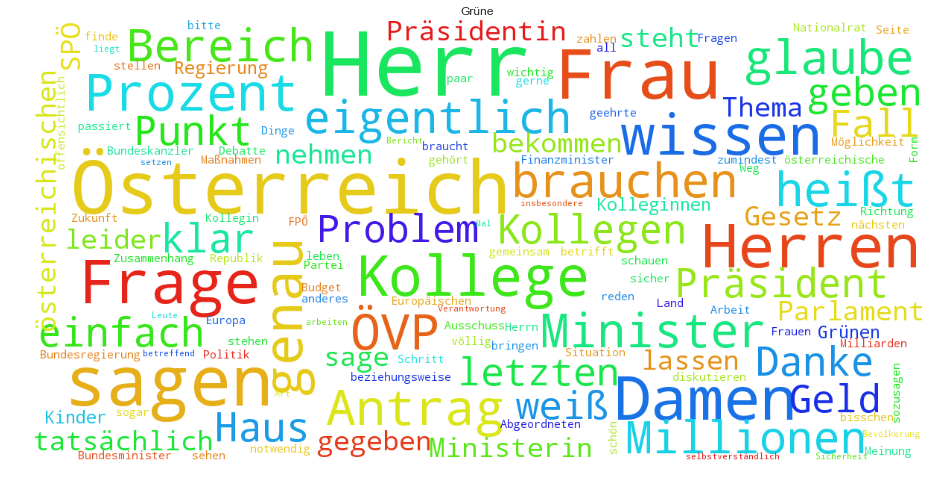

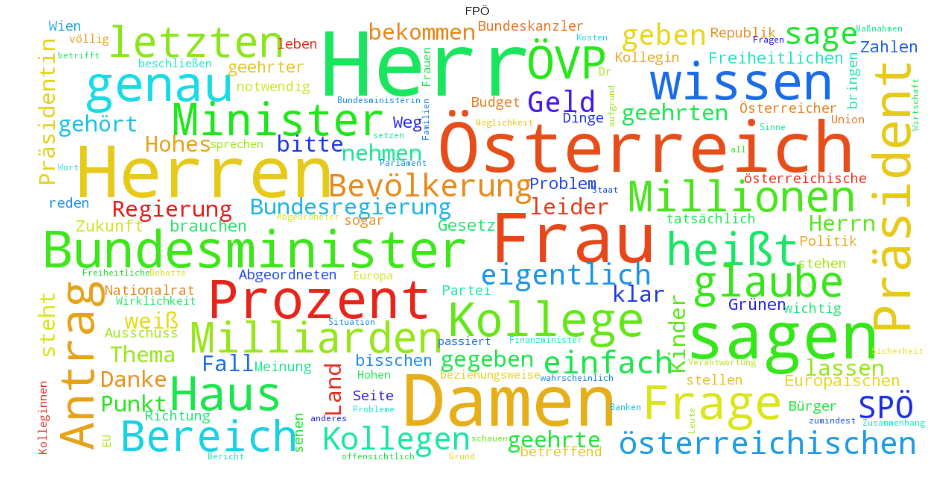

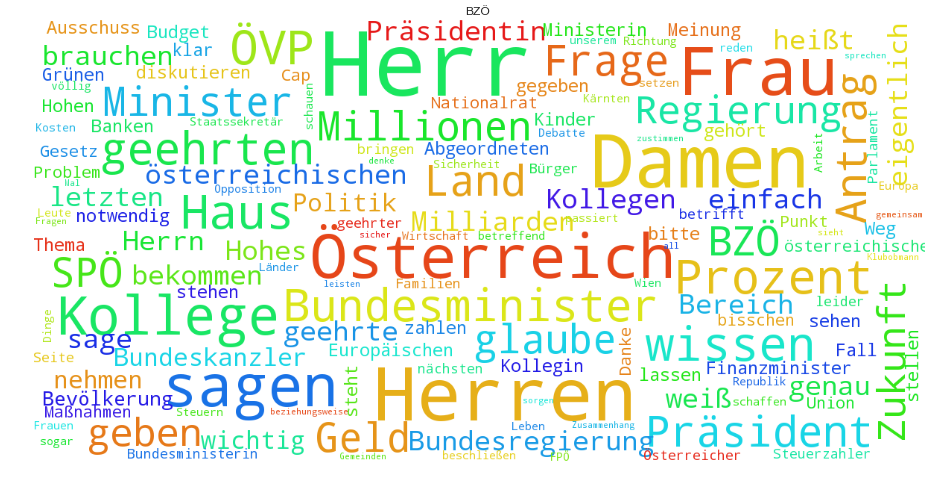

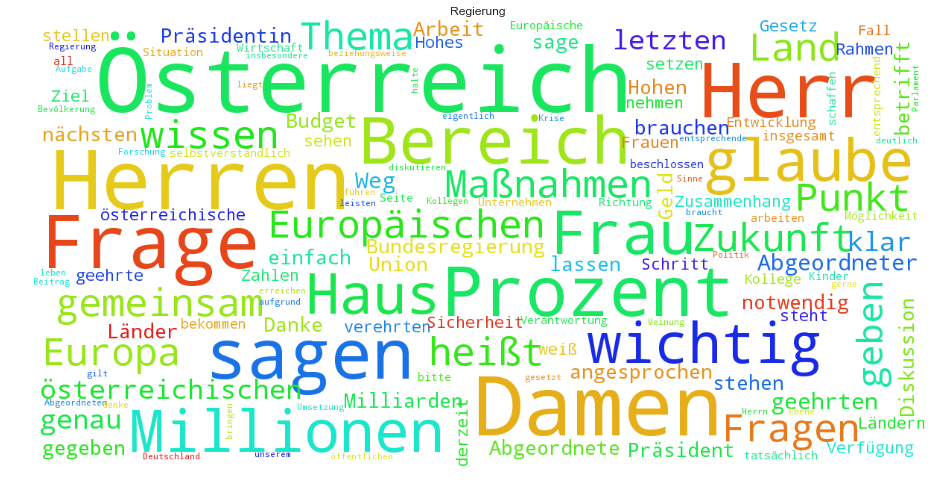

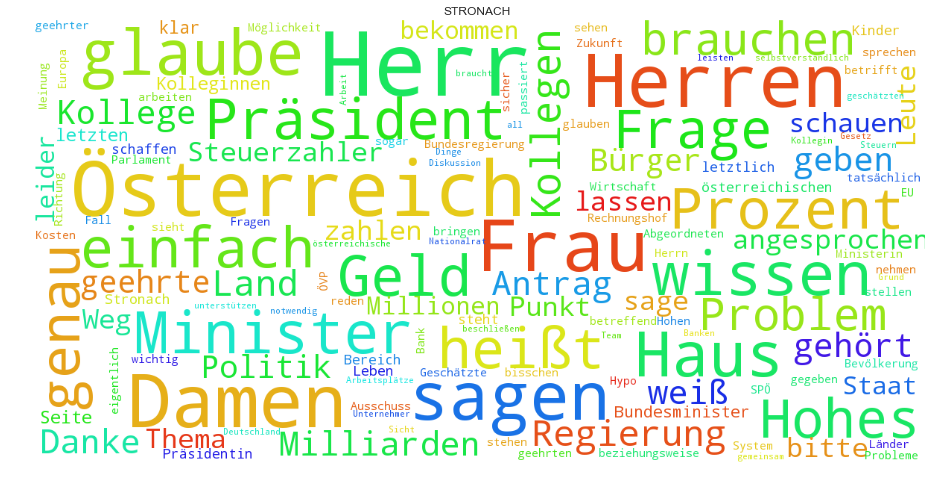

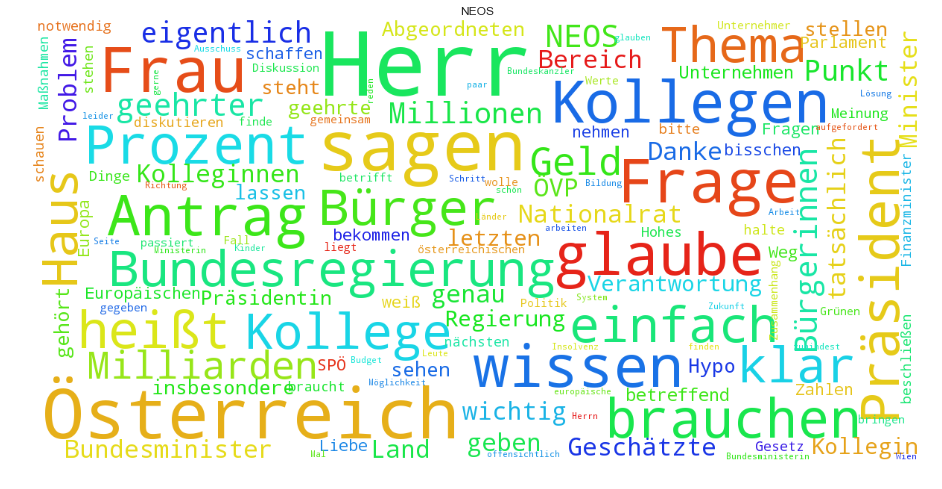

In [121]:
for partei in ('SPÖ', 'ÖVP', 'Grüne', 'FPÖ', 'BZÖ', 'Regierung', 'STRONACH', 'NEOS'):
    wc(df.loc[df.redner_partei == partei, 'rede_clean'], titel=partei)

In [122]:
def wc_woerter(df_temp, titel=None, max_words=1000):
    text = ' '.join(df_temp)
    # take relative word frequencies into account, lower max_font_size
    # wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(max_words = max_words, stopwords = STOPWORDS_GENERAL).generate(text)
    df_out = pd.DataFrame(wordcloud.words_, columns=['wort', titel])
    df_out.index = df_out.wort
    df_out = df_out.drop('wort', axis=1)
    return df_out

In [153]:
%%time

#parteien = ('SPÖ', 'ÖVP', 'Grüne', 'FPÖ', 'BZÖ', 'Regierung', 'STRONACH', 'NEOS')
#parteien = ('SPÖ', 'ÖVP', 'Grüne', 'FPÖ', 'BZÖ', 'STRONACH', 'NEOS')
#parteien = ('SPÖ', 'ÖVP', 'Grüne', 'FPÖ')
parteien = ('Regierung', 'SPÖ', 'ÖVP', 'FPÖ', 'Grüne')

df_woerter = pd.DataFrame()

for partei in parteien:
    df_temp = wc_woerter(df.loc[df.redner_partei == partei, 'rede_clean'], titel=partei)
    if df_woerter.empty:
        df_woerter = df_temp
    else:
        df_woerter = df_woerter.merge(df_temp, how='outer', left_index=True, right_index=True)
        
df_woerter_durchschnitt = wc_woerter(df.loc[df.redner_partei.isin(parteien),'rede_clean'], 
                                     titel='durchschnitt')

df_woerter = df_woerter.merge(df_woerter_durchschnitt, how='outer', left_index=True, right_index=True)

df_woerter = df_woerter / df_woerter.sum()

df_woerter = df_woerter.fillna(value=0)

df_woerter_delta = df_woerter.apply(lambda x: x - x['durchschnitt'], axis=1)

Wall time: 44.2 s


In [154]:
df_woerter_min = df_woerter.drop('durchschnitt', axis=1)
df_woerter_min = df_woerter_min.apply(lambda x: x - min(x), axis=1)
df_woerter_min[:10]

Regierung       SPÖ       ÖVP       FPÖ     Grüne
wort                                                           
AMS            0.000392  0.000000  0.000000  0.000000  0.000000
Abgeordnete    0.002270  0.000000  0.000129  0.000119  0.000643
Abgeordneten   0.000461  0.000124  0.000000  0.001217  0.001495
Abgeordneter   0.002591  0.000037  0.000000  0.000565  0.000366
Abkommen       0.000087  0.000202  0.000246  0.000137  0.000000
Abs            0.000000  0.000610  0.000887  0.000478  0.000541
Abschaffung    0.000000  0.000000  0.000000  0.000454  0.000000
Abschluss      0.000481  0.000334  0.000331  0.000000  0.000000
Absicherung    0.000000  0.000331  0.000000  0.000000  0.000000
Abstimmung     0.000000  0.000000  0.000000  0.000400  0.000367

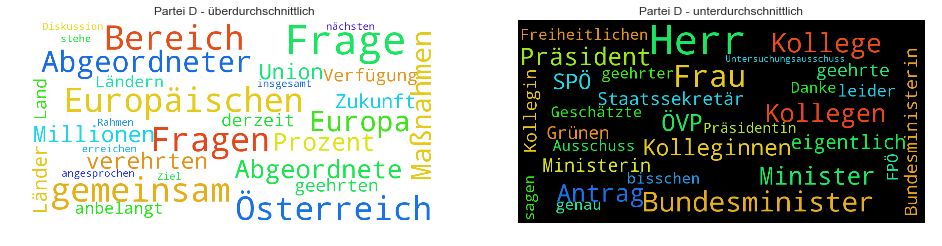

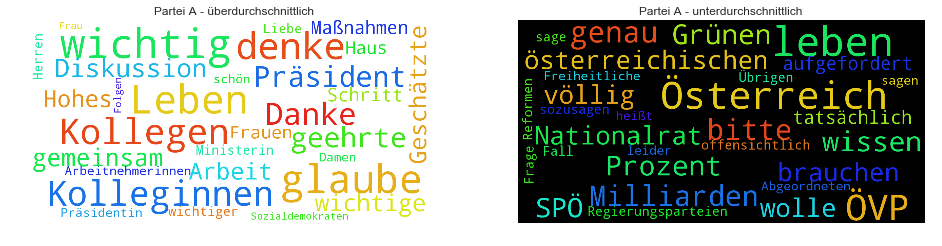

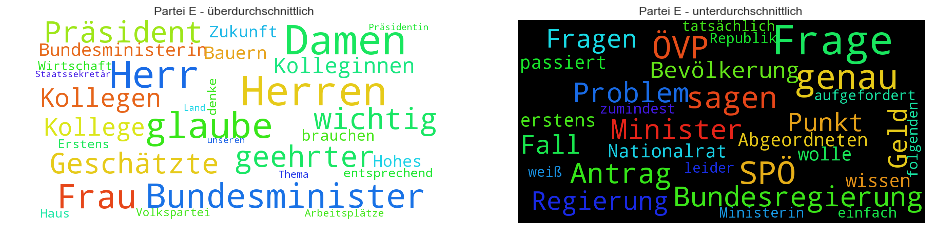

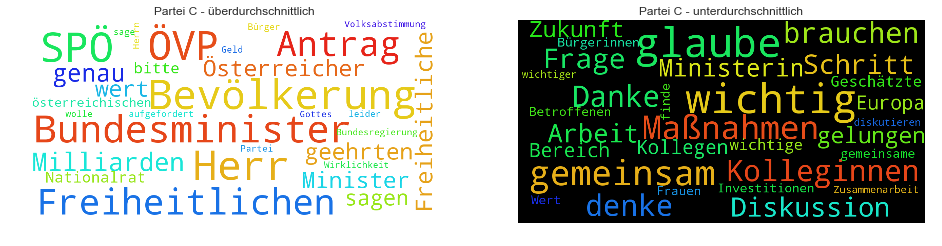

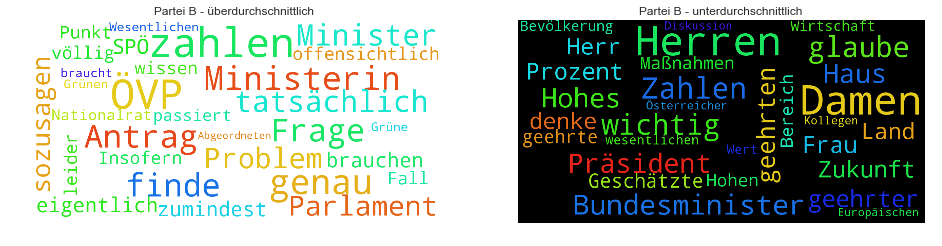

In [158]:
parteien_mapping = {'Regierung': 'Partei D', 
                    'SPÖ'      : 'Partei A', 
                    'ÖVP'      : 'Partei E', 
                    'FPÖ'      : 'Partei C', 
                    'Grüne'    : 'Partei B'}

for titel in df_woerter.columns.drop('durchschnitt'):
    woerter_plus = df_woerter_delta.loc[df_woerter_delta[titel] > 0, titel]
    woerter_minus = df_woerter_delta.loc[df_woerter_delta[titel] < 0, titel] * (-1)

    wordcloud_plus = WordCloud(max_font_size=40, relative_scaling=.5, background_color='white', 
                          scale=3, random_state=42, max_words=30)

    wordcloud_minus = WordCloud(max_font_size=40, relative_scaling=.5, background_color='black', 
                          scale=3, random_state=42, max_words=30)

    wordcloud_plus = WordCloud.generate_from_frequencies(wordcloud_plus,woerter_plus.to_dict().items())
    wordcloud_minus = WordCloud.generate_from_frequencies(wordcloud_minus,woerter_minus.to_dict().items())

    plt.figure(figsize=(16,8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_plus)
    plt.axis("off")
    plt.title(parteien_mapping[titel] + ' - überdurchschnittlich' )

    
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_minus)
    plt.axis("off")
    plt.title(parteien_mapping[titel] + ' - unterdurchschnittlich' )

    plt.savefig('wc_raetsel_' + parteien_mapping[titel].replace(' ','_') + '.png', 
                transparent=True, bbox_inches='tight', pad_inches=0)  
    
    plt.show()

In [159]:
df_woerter.loc[df_woerter.index.str.contains('grüne', flags=re.IGNORECASE)]

Regierung       SPÖ       ÖVP       FPÖ     Grüne  durchschnitt
wort                                                                   
Grüne    0.000000  0.000000  0.000327  0.000000  0.001366      0.000508
Grünen   0.000781  0.001331  0.002206  0.002772  0.002957      0.002140
grüne    0.000000  0.000000  0.000000  0.000412  0.000000      0.000000

In [160]:
df_woerter.loc[df_woerter.index.str.contains('freiheit', flags=re.IGNORECASE)]

Regierung       SPÖ       ÖVP       FPÖ     Grüne  \
wort                                                                
Freiheit              0.0  0.000000  0.000000  0.000391  0.000000   
Freiheitliche         0.0  0.000000  0.000000  0.001745  0.000406   
Freiheitlichen        0.0  0.000769  0.000675  0.002813  0.000985   

                durchschnitt  
wort                          
Freiheit            0.000000  
Freiheitliche       0.000551  
Freiheitlichen      0.001199

In [128]:
df_woerter.loc[df_woerter.index.str.contains('volksp', flags=re.IGNORECASE)]

Regierung  SPÖ       ÖVP  FPÖ     Grüne  durchschnitt
wort                                                              
Volkspartei        0.0  0.0  0.000611  0.0  0.000428           0.0

In [129]:
df_woerter.loc[df_woerter.index.str.contains('sozial', flags=re.IGNORECASE)]

Regierung       SPÖ       ÖVP       FPÖ     Grüne  \
wort                                                                  
Sozialdemokraten   0.000000  0.000542  0.000000  0.000333  0.000000   
Sozialdemokratie   0.000000  0.000526  0.000000  0.000502  0.000000   
Sozialminister     0.000000  0.000331  0.000000  0.000374  0.000000   
Sozialpartner      0.000356  0.000000  0.000000  0.000000  0.000000   
sozial             0.000451  0.000625  0.000419  0.000381  0.000462   
soziale            0.000825  0.001002  0.000745  0.000751  0.000782   
sozialen           0.000795  0.000928  0.000583  0.000488  0.000494   

                  durchschnitt  
wort                            
Sozialdemokraten      0.000000  
Sozialdemokratie      0.000000  
Sozialminister        0.000000  
Sozialpartner         0.000000  
sozial                0.000480  
soziale               0.000838  
sozialen              0.000662

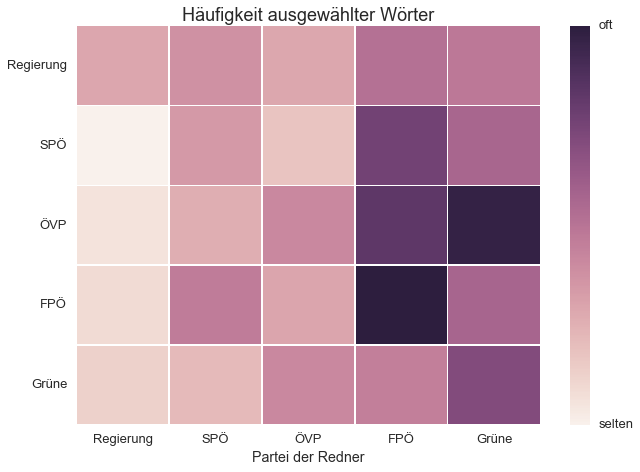

In [130]:
sample = {'Regierung': ('Regierung',), 
          'SPÖ': ('SPÖ', 'Sozialdemokraten'),
          'ÖVP': ('ÖVP', 'Volkspartei'), 
          'Grüne': ('Grüne', 'Grünen'), 
          'FPÖ': ('FPÖ', 'Freiheitlichen', 'Freiheitliche')
          }

woerter = [item for sublist in sample.values() for item in sublist]

df_temp = df_woerter[df_woerter.index.isin(woerter)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
for temp_partei in sample:
    df_temp.loc[temp_partei] = sum([df_temp.loc[wort,:] for wort in sample[temp_partei]])
    df_temp = df_temp.drop(labels=[wort for wort in sample[temp_partei] if wort != temp_partei], axis=0)

df_temp = df_temp.reindex(index=df_temp.columns)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit ausgewählter Wörter')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', '')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
sns.plt.savefig('wc_parteien.svg')

In [131]:
top_woerter = list()
for partei in parteien:
    top_woerter.extend(list(df_woerter.sort_values(by=partei, ascending=False)[:15][partei].index))
top_woerter = set(top_woerter)

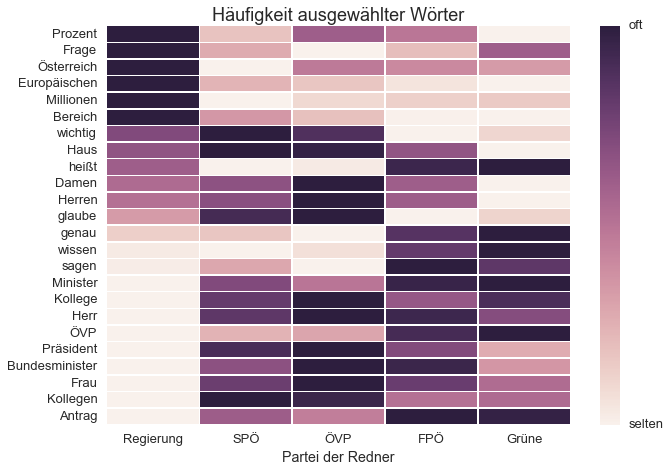

In [132]:
sample = top_woerter

df_temp = df_woerter[df_woerter.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
df_temp = df_temp.sort_values(by='Regierung', ascending=False)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit ausgewählter Wörter')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', '')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
#sns.plt.savefig('wc_partei_top_woerter.svg')

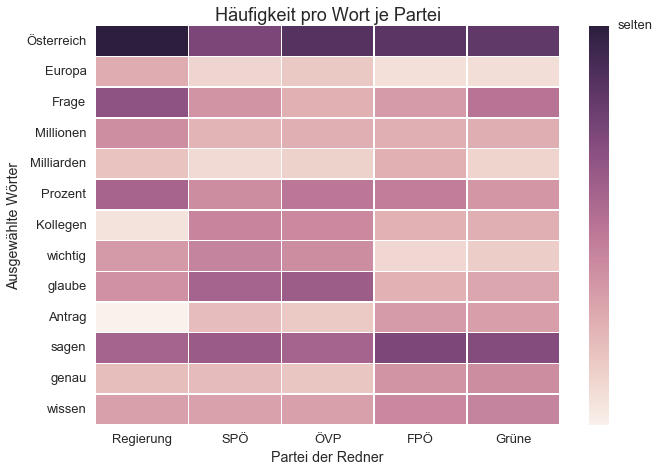

In [136]:
sample = ('Österreich', 'Europa', 'Frage', 'Millionen', 'Milliarden', 'Prozent',
          'Kollegen', 'wichtig', 'glaube',
          'Antrag', 'sagen', 'genau', 'wissen')

df_temp = df_woerter[df_woerter_delta.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
#df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
#df_temp = df_temp.sort_values(by='Regierung', ascending=False)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit pro Wort je Partei')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', 'Ausgewählte Wörter')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
sns.plt.savefig('wc_partei_woerter.svg')

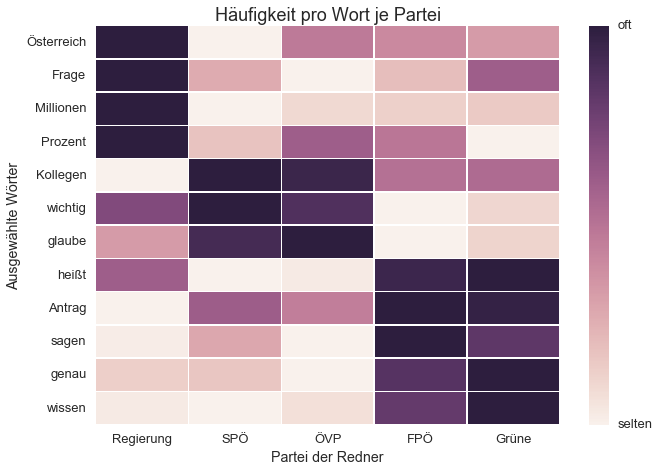

In [134]:
sample = ('Österreich', 'Frage', 'Millionen', 'Prozent',
          'Kollegen', 'wichtig', 'glaube',
          'heißt', 'Antrag', 'sagen', 'genau', 'wissen')

df_temp = df_woerter[df_woerter_delta.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
#df_temp = df_temp.sort_values(by='Regierung', ascending=False)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit pro Wort je Partei')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', 'Ausgewählte Wörter')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
#sns.plt.savefig('wc_partei_woerter.svg')

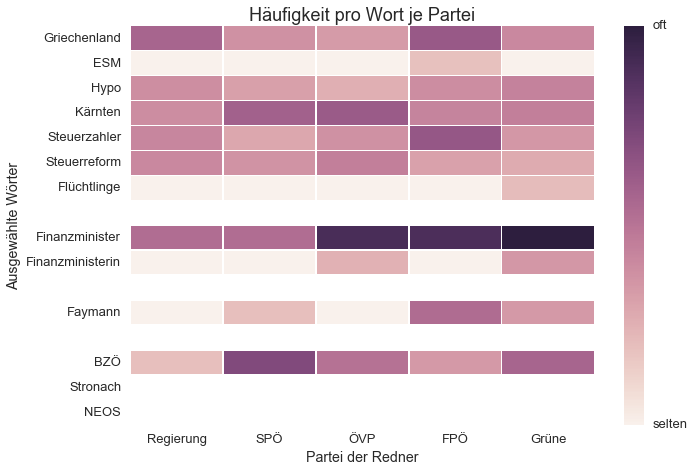

In [135]:
sample = (#'Österreich', 'Europa', 
          'Griechenland', 'ESM', 
          'Hypo', 'Kärnten',   
          'Steuerzahler', 'Steuerreform',
          'Flüchtlinge', 
          ' ',
#          'Millionen', 'Milliarden', 
          'Finanzminister', 'Finanzministerin',
          ' ',
          'Faymann', 
          ' ',
          'BZÖ', 'Stronach', 'NEOS',
#          'Molterer', 'Pröll', 'Spindelegger', 'Mitterlehner', 
          )
df_temp = df_woerter[df_woerter_delta.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
#df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
#df_temp = df_temp.sort_values(by='Regierung', ascending=False)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit pro Wort je Partei')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', 'Ausgewählte Wörter')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
#sns.plt.savefig('wc_partei_woerter.svg')

In [137]:
df.datum.dt.year.value_counts()

2009    4319
2011    3629
2014    3506
2010    3417
2012    3273
2007    3158
2015    3139
2013    2888
2008    2763
2016     371
2006     357
Name: datum, dtype: int64

In [161]:
%%time

jahre = range(2007,2016)

df_woerter = pd.DataFrame()

for jahr in jahre:
    df_temp = wc_woerter(df.loc[df.datum.dt.year == jahr, 'rede_clean'], titel=str(jahr))
    if df_woerter.empty:
        df_woerter = df_temp
    else:
        df_woerter = df_woerter.merge(df_temp, how='outer', left_index=True, right_index=True)
        
df_woerter_durchschnitt = wc_woerter(df.loc[df.redner_partei.isin(parteien),'rede_clean'], 
                                     titel='durchschnitt')

df_woerter = df_woerter.merge(df_woerter_durchschnitt, how='outer', left_index=True, right_index=True)

df_woerter = df_woerter / df_woerter.sum()

df_woerter = df_woerter.fillna(value=0)

df_woerter_delta = df_woerter.apply(lambda x: x - x['durchschnitt'], axis=1)

Wall time: 47.2 s


In [162]:
df_woerter_min = df_woerter.drop('durchschnitt', axis=1)
df_woerter_min = df_woerter_min.apply(lambda x: x - min(x), axis=1)
df_woerter_min[:10]

2007      2008      2009      2010      2011      2012  \
wort                                                                       
AMA           0.000000  0.000000  0.000000  0.000000  0.000000  0.000365   
AUA           0.000000  0.000753  0.000725  0.000000  0.000000  0.000000   
Abgeordnete   0.000247  0.000214  0.000395  0.000000  0.000218  0.000370   
Abgeordneten  0.000407  0.000673  0.000660  0.000173  0.000000  0.000214   
Abgeordneter  0.000364  0.000457  0.000530  0.000271  0.000048  0.000289   
Abkommen      0.000391  0.000594  0.000000  0.000457  0.000433  0.000884   
Abs           0.000289  0.000013  0.000265  0.000000  0.000016  0.000260   
Abschaffung   0.000345  0.000403  0.000000  0.000000  0.000398  0.000392   
Abschluss     0.000000  0.000336  0.000000  0.000000  0.000000  0.000345   
Abstimmung    0.000000  0.000459  0.000346  0.000000  0.000000  0.000340   

                  2013      2014      2015  
wort                                        
AMA           0.000000  0.000000  0.000000  
AUA           0.000000  0.000000  0.000000  
Abgeordnete   0.000271  0.000344  0.000205  
Abgeordneten  0.000297  0.000326  0.000093  
Abgeordneter  0.000135  0.000000  0.000137  
Abkommen      0.000565  0.000546  0.000511  
Abs           0.000353  0.000119  0.000018  
Abschaffung   0.000000  0.000000  0.000425  
Abschluss     0.000000  0.000000  0.000000  
Abstimmung    0.000357  0.000000  0.000000

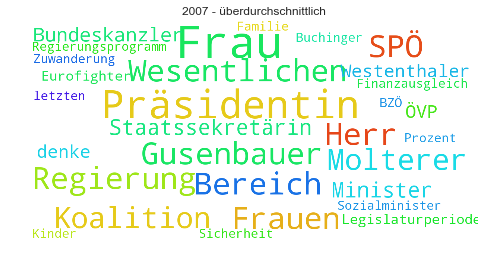

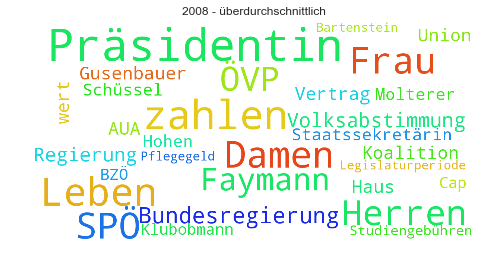

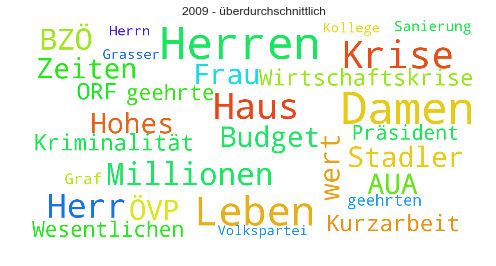

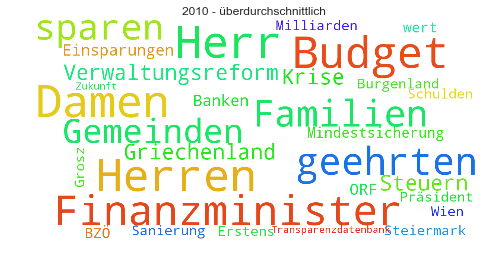

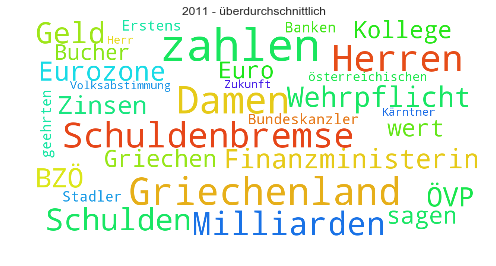

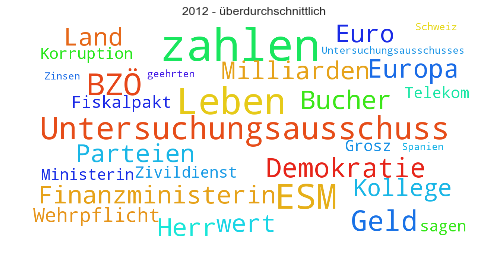

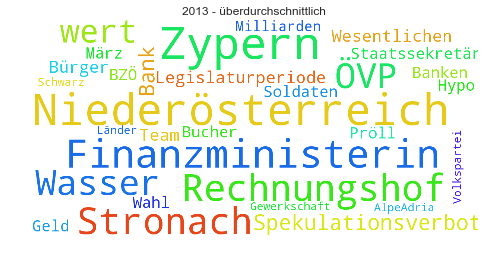

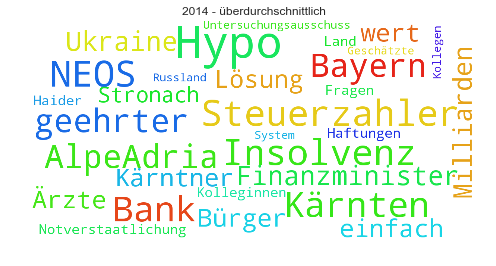

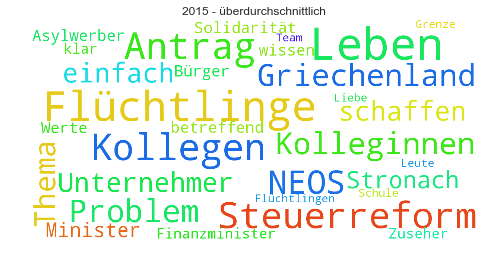

In [163]:
for titel in df_woerter.columns.drop('durchschnitt'):
    woerter_plus = df_woerter_delta.loc[df_woerter_delta[titel] > 0, titel]
    woerter_minus = df_woerter_delta.loc[df_woerter_delta[titel] < 0, titel] * (-1)

    wordcloud_plus = WordCloud(max_font_size=40, relative_scaling=.5, background_color='white', 
                          scale=3, random_state=42, max_words=30)

    wordcloud_minus = WordCloud(max_font_size=40, relative_scaling=.5, background_color='black', 
                          scale=3, random_state=42, max_words=30)

    wordcloud_plus = WordCloud.generate_from_frequencies(wordcloud_plus,woerter_plus.to_dict().items())
    wordcloud_minus = WordCloud.generate_from_frequencies(wordcloud_minus,woerter_minus.to_dict().items())

    plt.imshow(wordcloud_plus)
    plt.axis("off")
    plt.title(titel + ' - überdurchschnittlich' )
    
    plt.savefig('wc_jahr_' + titel + '.png', transparent=True, bbox_inches='tight', pad_inches=0)  
    
    plt.show()

In [141]:
df_woerter[:3]

2007      2008      2009      2010      2011      2012  \
wort                                                                      
AMA          0.000000  0.000000  0.000000  0.000000  0.000000  0.000365   
AUA          0.000000  0.000753  0.000725  0.000000  0.000000  0.000000   
Abgeordnete  0.001302  0.001268  0.001449  0.001055  0.001273  0.001425   

                 2013      2014     2015  durchschnitt  
wort                                                    
AMA          0.000000  0.000000  0.00000      0.000000  
AUA          0.000000  0.000000  0.00000      0.000000  
Abgeordnete  0.001325  0.001398  0.00126      0.001347

In [142]:
top_woerter = list()
for jahr in df_woerter.columns:
    top_woerter.extend(list(df_woerter.sort_values(by=jahr, ascending=False)[:20][jahr].index))
top_woerter = set(top_woerter)

In [143]:
top_woerter = list()
for jahr in df_woerter.columns:
    top_woerter.extend(list(df_woerter_delta.sort_values(by=jahr, ascending=False)[:5][jahr].index))
top_woerter = set(top_woerter)

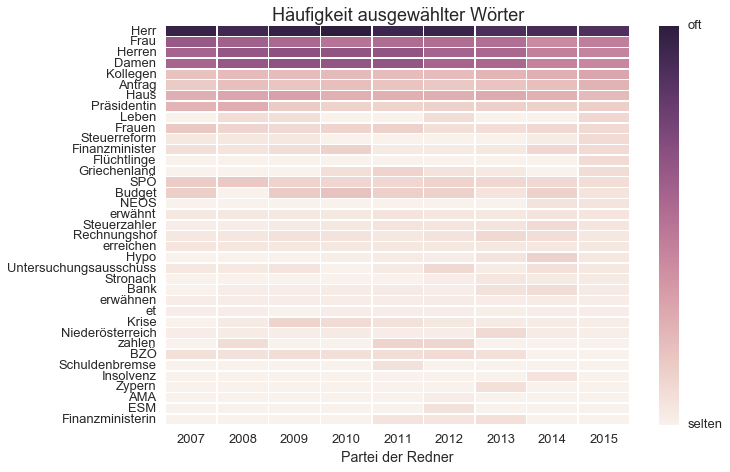

In [144]:
sample = top_woerter

df_temp = df_woerter[df_woerter.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
#df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
df_temp = df_temp.sort_values(by='2015', ascending=False)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit ausgewählter Wörter')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', '')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
#sns.plt.savefig('wc_jahr_top_woerter.svg')

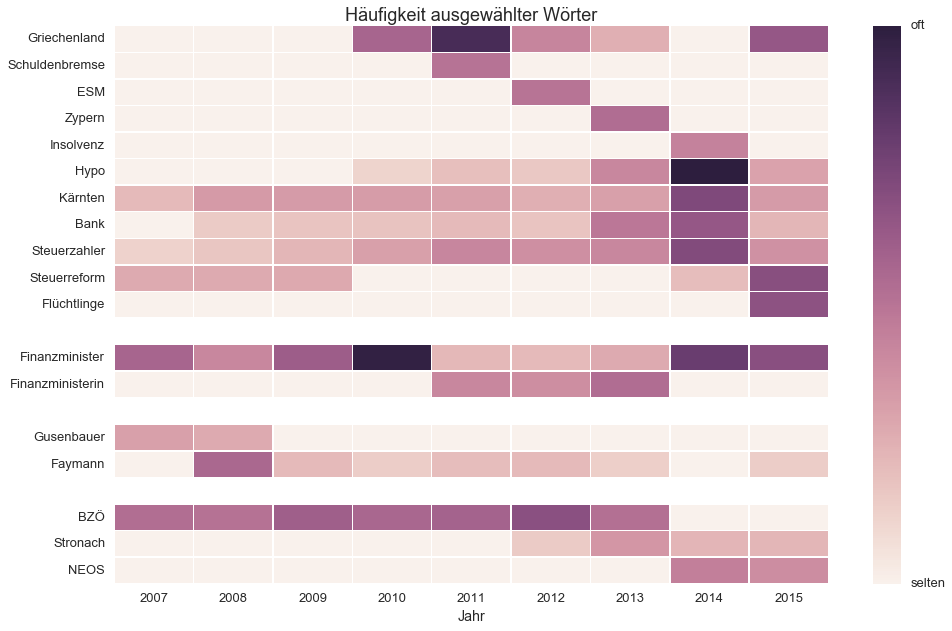

In [152]:
sample = (#'Österreich', 'Europa', 
          'Griechenland', 'Schuldenbremse', 'ESM', 'Zypern', 
          'Insolvenz', 'Hypo', 'Kärnten', 'Bank',  
          'Steuerzahler', 'Steuerreform',
          'Flüchtlinge', 
          ' ',
#          'Millionen', 'Milliarden', 
          'Finanzminister', 'Finanzministerin',
          ' ',
          'Gusenbauer', 'Faymann', 
          ' ',
          'BZÖ', 'Stronach', 'NEOS',
#          'Molterer', 'Pröll', 'Spindelegger', 'Mitterlehner', 
          )


df_temp = df_woerter[df_woerter_delta.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
#df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
#df_temp = df_temp.sort_values(by='Regierung', ascending=False)
plt.figure(figsize=(16,10))
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit ausgewählter Wörter')
sns.set(font_scale=1)
sns.axlabel('Jahr', '')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
sns.plt.savefig('wc_jahr_woerter.svg')

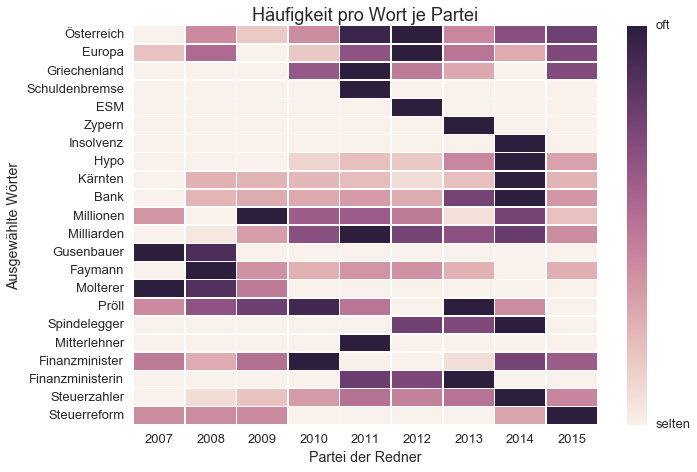

In [146]:
sample = ('Österreich', 'Europa', 
          'Griechenland', 'Schuldenbremse', 'ESM', 'Zypern', 
          'Insolvenz', 'Hypo', 'Kärnten', 'Bank',  
          'Millionen', 'Milliarden', 
          'Gusenbauer', 'Faymann', 
          'Molterer', 'Pröll', 'Spindelegger', 'Mitterlehner', 
          'Finanzminister', 'Finanzministerin',
          'Steuerzahler', 'Steuerreform')

df_temp = df_woerter[df_woerter_delta.index.isin(sample)]
df_temp = df_temp.drop('durchschnitt', axis=1)
df_temp = df_temp * 10000
df_temp = df_temp.reindex(index=sample)
df_temp = df_temp.apply(lambda x: (x - min(x))/max(x-min(x)), axis=1)
#df_temp = df_temp.sort_values(by='Regierung', ascending=False)
sns.set(context='talk', style='whitegrid', palette=sns.xkcd_palette(parteien_farben))
ax = sns.heatmap(df_temp, annot=False, linewidths=.5)
#sns.despine()
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.plt.title('Häufigkeit pro Wort je Partei')
sns.set(font_scale=1)
sns.axlabel('Partei der Redner', 'Ausgewählte Wörter')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, df_temp.max().max()])
cbar.set_ticklabels(['selten', 'oft'])
#sns.plt.savefig('wc_jahr_woerter.svg')